In [2]:
pip install lifelines



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd

# Загрузка данных
exprs = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/exprs_PRJNA805525.csv', index_col=0)
ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/ann_PRJNA805525.csv')

# Фильтрация пациентов
filtered_ann = ann[
    (ann['BRAF_status_binary'] == 'Wt') & 
    (ann['KRAS_status'] == 'Wild Type')
].copy()

# Получаем отфильтрованные данные экспрессии
exprs_filtered = exprs.iloc[filtered_ann.index]  # Используем iloc для позиционного доступа

# Создаем финальный датафрейм
data = filtered_ann.copy()

# Добавляем нужные гены (убедитесь, что названия точно совпадают)
genes_to_extract = ['MET', 'VIM', 'CDH1']
for gene in genes_to_extract:
    if gene in exprs.columns:
        data[gene] = exprs_filtered[gene].values  # Используем .values для прямого присвоения
    else:
        print(f"Ген {gene} не найден в данных экспрессии")

# Проверка результата
print("\nПервые 5 строк после объединения:")
print(data[['BRAF_status_binary', 'KRAS_status'] + genes_to_extract].head())

# Проверка на NaN
print("\nКоличество NaN значений по генам:")
print(data[genes_to_extract].isna().sum())

# Сохранение
data.to_csv('filtered_data.csv', index=False)
print("\nДанные успешно сохранены в filtered_data.csv")


Первые 5 строк после объединения:
  BRAF_status_binary KRAS_status       MET        VIM      CDH1
0                 Wt   Wild Type  7.815669  10.111796  8.619343
1                 Wt   Wild Type  6.834084  11.160493  7.263821
2                 Wt   Wild Type  6.842642   9.345677  8.772760
3                 Wt   Wild Type  7.492584  10.217455  7.949827
5                 Wt   Wild Type  7.461016   9.834099  8.302990

Количество NaN значений по генам:
MET     0
VIM     0
CDH1    0
dtype: int64

Данные успешно сохранены в filtered_data_kp.csv


Медиана MET: 7.45
Распределение пациентов:
MET_group
High    39
Low     39
Name: count, dtype: int64


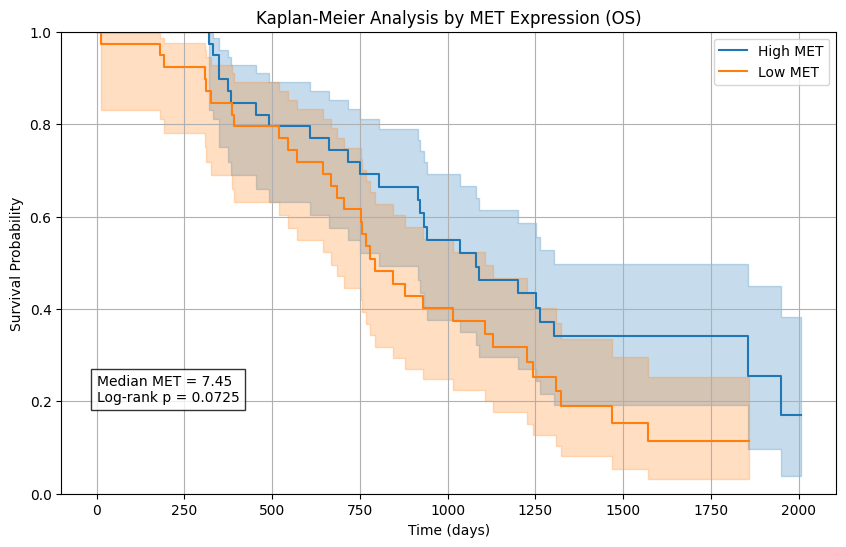


Данные с группами сохранены: /mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data.csv')

# Выбор конечной точки (можно изменить на PFS/PFS_FLAG)
time_col = 'OS'       # Общая выживаемость
event_col = 'OS_FLAG' # События для общей выживаемости

# 1. Разделение по уровню MET
median_met = data['MET'].median()
data['MET_group'] = ['High' if x > median_met else 'Low' for x in data['MET']]

print(f"Медиана MET: {median_met:.2f}")
print("Распределение пациентов:")
print(data['MET_group'].value_counts())

# 2. Kaplan-Meier анализ
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

# Для группы с высоким MET
high_met = data[data['MET_group'] == 'High']
kmf.fit(high_met[time_col], high_met[event_col], label='High MET')
ax = kmf.plot_survival_function(ci_show=True)

# Для группы с низким MET
low_met = data[data['MET_group'] == 'Low']
kmf.fit(low_met[time_col], low_met[event_col], label='Low MET')
kmf.plot_survival_function(ax=ax, ci_show=True)

# 3. Log-rank тест
results = logrank_test(
    high_met[time_col], 
    low_met[time_col],
    event_observed_A=high_met[event_col],
    event_observed_B=low_met[event_col]
)

# 4. Оформление графика
plt.title(f'Kaplan-Meier Analysis by MET Expression ({time_col})')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.ylim(0, 1)

# Добавление статистики
plt.text(0.6, 0.2, 
         f'Median MET = {median_met:.2f}\nLog-rank p = {results.p_value:.4f}',
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# 5. Сохранение данных с группами
output_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv'
data.to_csv(output_path, index=False)
print(f"\nДанные с группами сохранены: {output_path}")

Медиана MET: 7.45
Распределение пациентов:
MET_group
High    39
Low     39
Name: count, dtype: int64


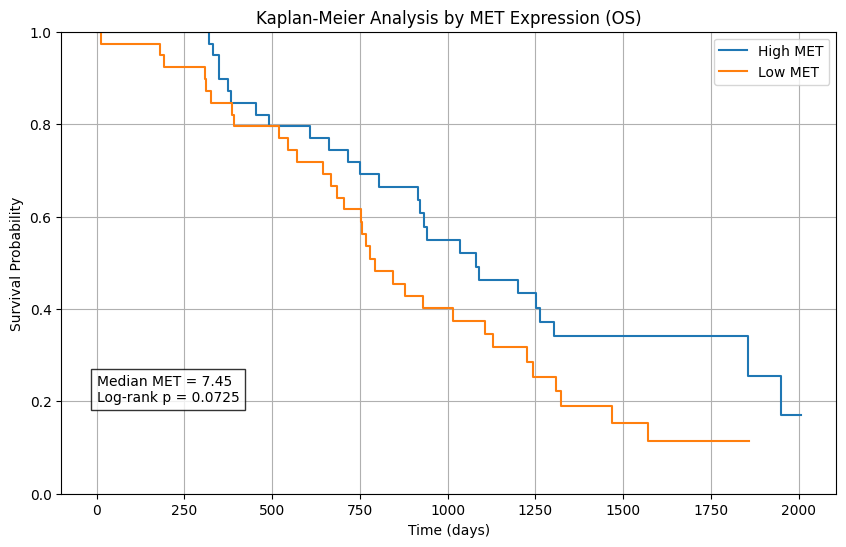


Данные с группами сохранены: /mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv

Доверительные интервалы (95%) для High MET:
            High MET_lower  High MET_upper
0.000000          1.000000        1.000000
319.754709        0.831593        0.996348
330.746277        0.810158        0.986922
347.733246        0.749414        0.960218
374.712549        0.719027        0.944530

Доверительные интервалы (95%) для Low MET:
            Low MET_lower  Low MET_upper
0.000000         1.000000       1.000000
13.989268        0.831593       0.996348
181.860491       0.810158       0.986922
190.853592       0.780163       0.974522
308.763141       0.749414       0.960218


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/filtered_data.csv')

# Выбор конечной точки (можно изменить на PFS/PFS_FLAG)
time_col = 'OS'       # Общая выживаемость
event_col = 'OS_FLAG' # События для общей выживаемости

# 1. Разделение по уровню MET
median_met = data['MET'].median()
data['MET_group'] = ['High' if x > median_met else 'Low' for x in data['MET']]

print(f"Медиана MET: {median_met:.2f}")
print("Распределение пациентов:")
print(data['MET_group'].value_counts())

# 2. Kaplan-Meier анализ
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

# Для группы с высоким MET
high_met = data[data['MET_group'] == 'High']
kmf.fit(high_met[time_col], high_met[event_col], label='High MET')
ax = kmf.plot_survival_function(ci_show=False)

# Сохраняем доверительные интервалы для High MET
ci_high = kmf.confidence_interval_.copy()
ci_high.columns = ['High MET_lower', 'High MET_upper']

# Для группы с низким MET
low_met = data[data['MET_group'] == 'Low']
kmf.fit(low_met[time_col], low_met[event_col], label='Low MET')
kmf.plot_survival_function(ax=ax, ci_show=False)

# Сохраняем доверительные интервалы для Low MET
ci_low = kmf.confidence_interval_.copy()
ci_low.columns = ['Low MET_lower', 'Low MET_upper']

# 3. Log-rank тест
results = logrank_test(
    high_met[time_col], 
    low_met[time_col],
    event_observed_A=high_met[event_col],
    event_observed_B=low_met[event_col]
)

# 4. Оформление графика
plt.title(f'Kaplan-Meier Analysis by MET Expression ({time_col})')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.ylim(0, 1)

# Добавление статистики
plt.text(0.6, 0.2, 
         f'Median MET = {median_met:.2f}\nLog-rank p = {results.p_value:.4f}',
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# 5. Сохранение данных с группами
output_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv'
data.to_csv(output_path, index=False)
print(f"\nДанные с группами сохранены: {output_path}")

# 6. Вывод доверительных интервалов
print("\nДоверительные интервалы (95%) для High MET:")
print(ci_high.head())

print("\nДоверительные интервалы (95%) для Low MET:")
print(ci_low.head())


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data.csv')

# Разделение по медиане MET (50-й перцентиль)
median_met = data['MET'].median()
data['MET_high'] = (data['MET'] > median_met).astype(int)

# Инициализация и обучение модели
cph = CoxPHFitter()
cph.fit(data[['OS', 'OS_FLAG', 'MET_high']], 
        duration_col='OS', 
        event_col='OS_FLAG')

# Вывод результатов
print(cph.print_summary())


<lifelines.CoxPHFitter: fitted with 78 total observations, 20 right-censored observations>
             duration col = 'OS'
                event col = 'OS_FLAG'
      baseline estimation = breslow
   number of observations = 78
number of events observed = 58
   partial log-likelihood = -212.15
         time fit was run = 2025-05-12 07:30:51 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
MET_high  -0.48      0.62      0.27           -1.00            0.05                0.37                1.05

           cmp to     z    p  -log2(p)
covariate                             
MET_high     0.00 -1.78 0.08      3.73
---
Concordance = 0.56
Partial AIC = 426.30
log-likelihood ratio test = 3.19 on 1 df
-log2(p) of ll-ratio test = 3.76

None


17-й перцентиль MET: 6.68
83-й перцентиль MET: 7.98

Распределение пациентов:
MET_group
High (верхние 17%)    14
Low (нижние 17%)      14
Name: count, dtype: int64


/tmp/ipykernel_814/1621067202.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_groups['is_high'] = (extreme_groups['MET_group'] == 'High (верхние 17%)').astype(int)


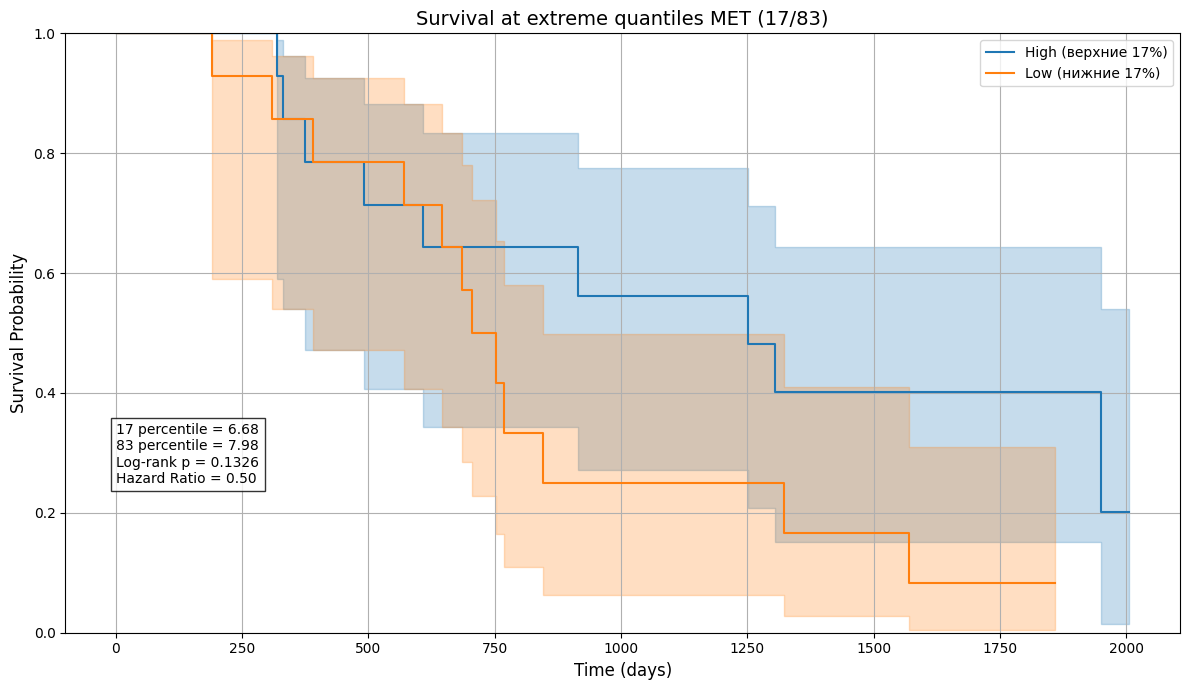

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/filtered_data.csv')

# 1. Определение квантилей 17% и 83%
low_quantile = data['MET'].quantile(0.17)
high_quantile = data['MET'].quantile(0.83)

print(f"17-й перцентиль MET: {low_quantile:.2f}")
print(f"83-й перцентиль MET: {high_quantile:.2f}")

# 2. Разделение на 3 группы
data['MET_group'] = np.select(
    [
        data['MET'] <= low_quantile,
        data['MET'] >= high_quantile,
    ],
    [
        'Low (нижние 17%)',
        'High (верхние 17%)',
    ],
    default='Middle (центральные 66%)'
)

# 3. Анализ только крайних групп
extreme_groups = data[data['MET_group'].isin(['Low (нижние 17%)', 'High (верхние 17%)'])]

print("\nРаспределение пациентов:")
print(extreme_groups['MET_group'].value_counts())

# 4. Kaplan-Meier анализ
plt.figure(figsize=(12, 7))
kmf = KaplanMeierFitter()

# Визуализация
for name, group in extreme_groups.groupby('MET_group'):
    kmf.fit(group['OS'], group['OS_FLAG'], label=name)
    kmf.plot_survival_function(ci_show=True)

# 5. Статистический анализ
groups = extreme_groups['MET_group'].unique()
result = logrank_test(
    extreme_groups[extreme_groups['MET_group']==groups[0]]['OS'],
    extreme_groups[extreme_groups['MET_group']==groups[1]]['OS'],
    event_observed_A=extreme_groups[extreme_groups['MET_group']==groups[0]]['OS_FLAG'],
    event_observed_B=extreme_groups[extreme_groups['MET_group']==groups[1]]['OS_FLAG']
)

# Cox-регрессия
cph = CoxPHFitter()
extreme_groups['is_high'] = (extreme_groups['MET_group'] == 'High (верхние 17%)').astype(int)
cph.fit(extreme_groups[['OS', 'OS_FLAG', 'is_high']], duration_col='OS', event_col='OS_FLAG')

# 6. Визуализация результатов
plt.title('Survival at extreme quantiles MET (17/83)', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(True)
plt.ylim(0, 1)

stats_text = f"""17 percentile = {low_quantile:.2f}
83 percentile = {high_quantile:.2f}
Log-rank p = {result.p_value:.4f}
Hazard Ratio = {np.exp(cph.params_['is_high']):.2f}"""
plt.text(0.6, 0.25, stats_text, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/MET_quantile_analysis.png', dpi=300)
plt.show()

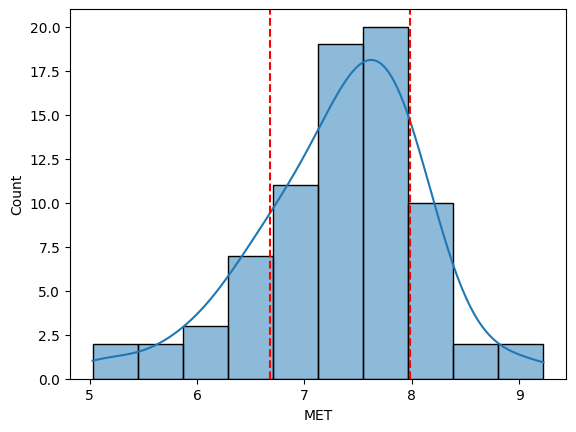

In [20]:
import seaborn as sns
sns.histplot(data['MET'], kde=True)
plt.axvline(low_quantile, color='red', linestyle='--')
plt.axvline(high_quantile, color='red', linestyle='--')

In [21]:
import pandas as pd
from lifelines import CoxPHFitter

# Загрузка данных (предполагаем, что файл содержит колонки: 'OS', 'OS_FLAG', 'MET')
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data.csv')

# Определение границ
low_q, high_q = data['MET'].quantile([0.17, 0.83])
data['MET_group'] = 'Middle'
data.loc[data['MET'] <= low_q, 'MET_group'] = 'Low'
data.loc[data['MET'] >= high_q, 'MET_group'] = 'High'

# Фильтрация только крайних групп
extreme_data = data[data['MET_group'].isin(['Low', 'High'])]

In [22]:
# Создание бинарной переменной (1 = High MET, 0 = Low MET)
extreme_data['MET_high'] = (extreme_data['MET_group'] == 'High').astype(int)

# Инициализация модели
cph = CoxPHFitter()

# Обучение модели
cph.fit(extreme_data[['OS', 'OS_FLAG', 'MET_high']], 
        duration_col='OS', 
        event_col='OS_FLAG')

# Вывод результатов
print(cph.print_summary())

/tmp/ipykernel_17995/1168346663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_data['MET_high'] = (extreme_data['MET_group'] == 'High').astype(int)


<lifelines.CoxPHFitter: fitted with 28 total observations, 7 right-censored observations>
             duration col = 'OS'
                event col = 'OS_FLAG'
      baseline estimation = breslow
   number of observations = 28
number of events observed = 21
   partial log-likelihood = -55.29
         time fit was run = 2025-05-08 19:29:26 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
MET_high  -0.68      0.50      0.46           -1.59            0.22                0.20                1.25

           cmp to     z    p  -log2(p)
covariate                             
MET_high     0.00 -1.48 0.14      2.84
---
Concordance = 0.57
Partial AIC = 112.58
log-likelihood ratio test = 2.24 on 1 df
-log2(p) of ll-ratio test = 2.89

None


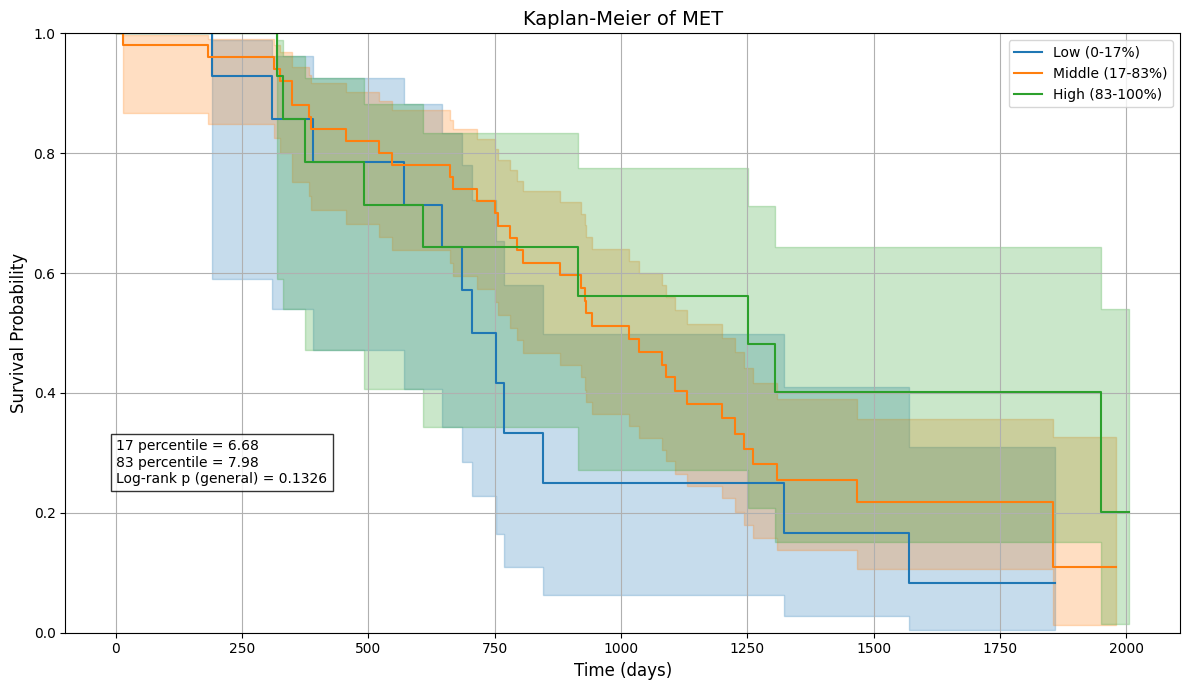


Результаты парных log-rank тестов:
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                test_statistic    p  -log2(p)
High (83-100%) Low (0-17%)                2.26 0.13      2.91
               Middle (17-83%)            0.86 0.35      1.50
Low (0-17%)    Middle (17-83%)            1.70 0.19      2.38


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import pairwise_logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/filtered_data.csv')

# Определение квантилей 17% и 83%
low_q = data['MET'].quantile(0.17)
high_q = data['MET'].quantile(0.83)

# Разделение на 3 группы
data['MET_group'] = np.select(
    [
        data['MET'] <= low_q,
        (data['MET'] > low_q) & (data['MET'] < high_q),
        data['MET'] >= high_q
    ],
    [
        'Low (0-17%)',
        'Middle (17-83%)',
        'High (83-100%)'
    ]
)

# Kaplan-Meier анализ для всех 3 групп
plt.figure(figsize=(12, 7))
kmf = KaplanMeierFitter()

for group in ['Low (0-17%)', 'Middle (17-83%)', 'High (83-100%)']:
    subset = data[data['MET_group'] == group]
    kmf.fit(subset['OS'], subset['OS_FLAG'], label=group)
    kmf.plot_survival_function(ci_show=True)

# Парные log-rank тесты
results = pairwise_logrank_test(
    data['OS'],
    data['MET_group'],
    data['OS_FLAG']
)

# Оформление графика
plt.title('Kaplan-Meier of MET', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(True)
plt.ylim(0, 1)

# Добавление статистики
stats_text = f"""17 percentile = {low_q:.2f}
83 percentile = {high_q:.2f}
Log-rank p (general) = {results.p_value.min():.4f}"""
plt.text(0.6, 0.25, stats_text, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('MET_3_groups_KM.png', dpi=300)
plt.show()

# Вывод результатов log-rank тестов
print("\nРезультаты парных log-rank тестов:")
print(results)

In [6]:
# Подготовка данных для Cox-регрессии
data['MET_group_encoded'] = data['MET_group'].map({
    'Low (0-17%)': 0,
    'Middle (17-83%)': 1,
    'High (83-100%)': 2
})

# Мультикатегориальная Cox-регрессия
cph = CoxPHFitter()
cph.fit(data[['OS', 'OS_FLAG', 'MET_group_encoded']], 
        duration_col='OS', 
        event_col='OS_FLAG')

# Вывод результатов
print("\nCox-регрессия (3 группы, Middle как референс):")
print(cph.print_summary())



Cox-регрессия (3 группы, Middle как референс):


<lifelines.CoxPHFitter: fitted with 78 total observations, 20 right-censored observations>
             duration col = 'OS'
                event col = 'OS_FLAG'
      baseline estimation = breslow
   number of observations = 78
number of events observed = 58
   partial log-likelihood = -212.29
         time fit was run = 2025-05-12 07:42:42 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
MET_group_encoded -0.39      0.68      0.23           -0.83            0.06                0.44                1.06

                   cmp to     z    p  -log2(p)
covariate                                     
MET_group_encoded    0.00 -1.71 0.09      3.52
---
Concordance = 0.55
Partial AIC = 426.57
log-likelihood ratio test = 2.93 on 1 df
-log2(p) of ll-ratio test = 3.52

None


In [7]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter

# Загрузка данных
expression = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/cohort_2_expr_emt_signatures.csv')
clinical = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/raw/ann_PRJNA805525.csv')

# Объединение данных по sample_id (предполагая, что порядок строк совпадает)
clinical['sample_id'] = expression['sample_id']
data = pd.merge(expression, clinical, on='sample_id')

# Выбор EMT-генов (исключаем не-генные колонки)
non_gene_cols = ['sample_id', 'OS', 'OS_FLAG', 'PFS', 'PFS_FLAG', 'Patient', 'Cohort', 'Gender']
emt_genes = [col for col in data.columns if col not in non_gene_cols]

# Создание EMT-индекса (усреднение Z-скоров генов EMT)
data['EMT_index'] = data[emt_genes].mean(axis=1)

TypeError: unsupported operand type(s) for +: 'float' and 'str'

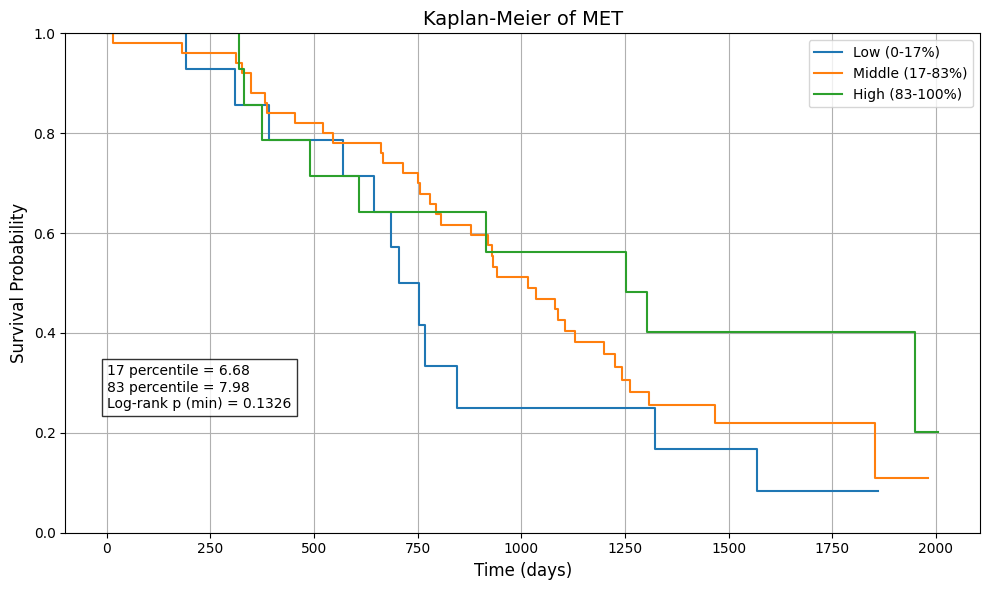


Доверительные интервалы (95%) для группы Low (0-17%):
            Low (0-17%)_lower  Low (0-17%)_upper
0.000000             1.000000           1.000000
190.853592           0.590767           0.989620
308.763141           0.539448           0.962232
390.700285           0.472464           0.925365
570.562308           0.406302           0.881879

Доверительные интервалы (95%) для группы High (83-100%):
            High (83-100%)_lower  High (83-100%)_upper
0.000000                1.000000              1.000000
319.754709              0.590767              0.989620
330.746277              0.539448              0.962232
374.712549              0.472464              0.925365
490.623631              0.406302              0.881879

Результаты парных log-rank тестов:
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                test_statistic    p  -log2(p)
Hi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/filtered_data.csv')

# Определение квантилей 17% и 83%
low_q = data['MET'].quantile(0.17)
high_q = data['MET'].quantile(0.83)

# Разделение на 3 группы
data['MET_group'] = np.select(
    [
        data['MET'] <= low_q,
        (data['MET'] > low_q) & (data['MET'] < high_q),
        data['MET'] >= high_q
    ],
    [
        'Low (0-17%)',
        'Middle (17-83%)',
        'High (83-100%)'
    ]
)

# Kaplan-Meier анализ для всех 3 групп
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

# Для сохранения CI
ci_dict = {}

for group in ['Low (0-17%)', 'Middle (17-83%)', 'High (83-100%)']:
    subset = data[data['MET_group'] == group]
    kmf.fit(subset['OS'], subset['OS_FLAG'], label=group)
    kmf.plot_survival_function(ci_show=False)
    
    # Сохраняем доверительные интервалы только для Low и High
    if group in ['Low (0-17%)', 'High (83-100%)']:
        ci_df = kmf.confidence_interval_.copy()
        ci_df.columns = [f'{group}_lower', f'{group}_upper']
        ci_dict[group] = ci_df

# Парные log-rank тесты
results = pairwise_logrank_test(
    data['OS'],
    data['MET_group'],
    data['OS_FLAG']
)

# Оформление графика
plt.title('Kaplan-Meier of MET', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(True)
plt.ylim(0, 1)

# Добавление статистики
stats_text = f"""17 percentile = {low_q:.2f}
83 percentile = {high_q:.2f}
Log-rank p (min) = {results.p_value.min():.4f}"""
plt.text(0.6, 0.25, stats_text, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('MET_3_groups_KM_no_CI.png', dpi=300)
plt.show()

# Вывод доверительных интервалов
for group, ci_df in ci_dict.items():
    print(f"\nДоверительные интервалы (95%) для группы {group}:")
    print(ci_df.head())

# Вывод результатов log-rank тестов
print("\nРезультаты парных log-rank тестов:")
print(results)


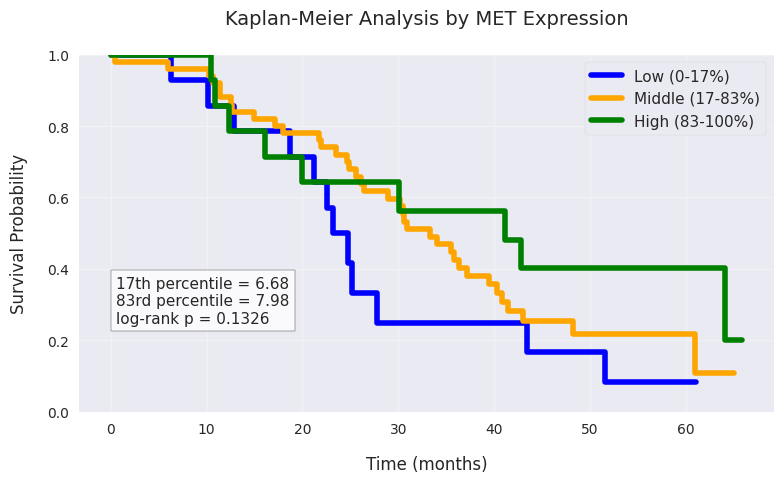


Результаты парных log-rank тестов:
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                test_statistic    p  -log2(p)
High (83-100%) Low (0-17%)                2.26 0.13      2.91
               Middle (17-83%)            0.86 0.35      1.50
Low (0-17%)    Middle (17-83%)            1.70 0.19      2.38


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/filtered_data.csv')

# Конвертация дней в месяцы (1 месяц = 30.44 дней)
data['OS_months'] = data['OS'] / 30.44

# Определение квантилей 17% и 83%
low_q = data['MET'].quantile(0.17)
high_q = data['MET'].quantile(0.83)

# Разделение на 3 группы
data['MET_group'] = np.select(
    [
        data['MET'] <= low_q,
        (data['MET'] > low_q) & (data['MET'] < high_q),
        data['MET'] >= high_q
    ],
    [
        'Low (0-17%)',
        'Middle (17-83%)',
        'High (83-100%)'
    ]
)

# Настройки стиля
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'lines.linewidth': 4,  # Увеличенная толщина линий
    'figure.figsize': (8, 5)  # Уменьшенный размер
})

# Kaplan-Meier анализ
fig, ax = plt.subplots()
kmf = KaplanMeierFitter()

# Исходные цвета 
colors = {
    'Low (0-17%)': 'blue',
    'Middle (17-83%)': 'orange',
    'High (83-100%)': 'green'
}

for group in ['Low (0-17%)', 'Middle (17-83%)', 'High (83-100%)']:
    subset = data[data['MET_group'] == group]
    kmf.fit(subset['OS_months'], subset['OS_FLAG'], label=group)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=colors[group])

# Парные log-rank тесты
results = pairwise_logrank_test(
    data['OS_months'],
    data['MET_group'],
    data['OS_FLAG']
)

# Оформление графика
ax.set_title('Kaplan-Meier Analysis by MET Expression', pad=22)
ax.set_xlabel('Time (months)', labelpad=14)
ax.set_ylabel('Survival Probability', labelpad=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

# Добавление статистики
stats_text = f"""17th percentile = {low_q:.2f}
83rd percentile = {high_q:.2f}
log-rank p = {results.p_value.min():.4f}"""
ax.text(0.6, 0.25, stats_text, 
        bbox=dict(facecolor='white', alpha=0.8),
        fontsize=11)

# Легенда
ax.legend(frameon=True, framealpha=0.8)

plt.tight_layout()
plt.savefig('MET_3_groups_KM_final.png', dpi=300, bbox_inches='tight')
plt.show()

# Вывод результатов
print("\nРезультаты парных log-rank тестов:")
print(results)


График сохранен как MET_3_groups_KM_with_median.png
Данные с группами сохранены: /mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_3_groups.csv


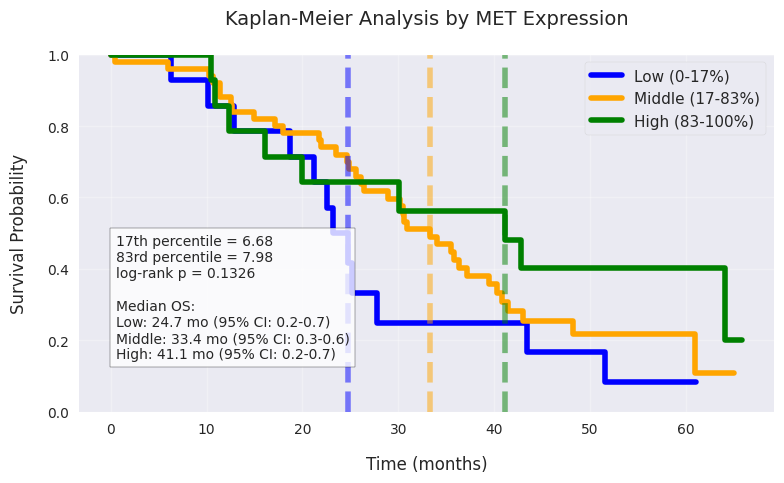


Результаты парных log-rank тестов:
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                test_statistic    p  -log2(p)
High (83-100%) Low (0-17%)                2.26 0.13      2.91
               Middle (17-83%)            0.86 0.35      1.50
Low (0-17%)    Middle (17-83%)            1.70 0.19      2.38

Медианная выживаемость:
Low (0-17%): 24.7 месяцев (95% ДИ: 0.2-0.7)
Middle (17-83%): 33.4 месяцев (95% ДИ: 0.3-0.6)
High (83-100%): 41.1 месяцев (95% ДИ: 0.2-0.7)


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/filtered_data.csv')

# Конвертация дней в месяцы (1 месяц = 30.44 дней)
data['OS_months'] = data['OS'] / 30.44

# Определение квантилей 17% и 83%
low_q = data['MET'].quantile(0.17)
high_q = data['MET'].quantile(0.83)

# Разделение на 3 группы
data['MET_group'] = np.select(
    [
        data['MET'] <= low_q,
        (data['MET'] > low_q) & (data['MET'] < high_q),
        data['MET'] >= high_q
    ],
    [
        'Low (0-17%)',
        'Middle (17-83%)',
        'High (83-100%)'
    ]
)

# Настройки стиля
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'lines.linewidth': 4,
    'figure.figsize': (8, 5)
})

# Kaplan-Meier анализ
fig, ax = plt.subplots()
kmf = KaplanMeierFitter()

# Функция для расчета доверительных интервалов медианы
def get_median_ci(kmf):
    if kmf.median_survival_time_ is np.inf:
        return (np.inf, np.inf)
    
    ci_df = kmf.confidence_interval_
    times = ci_df.index.values
    median_time = kmf.median_survival_time_
    
    closest_idx = np.argmin(np.abs(times - median_time))
    
    return (ci_df.iloc[closest_idx, 0], ci_df.iloc[closest_idx, 1])

# Цвета для групп
colors = {
    'Low (0-17%)': 'blue',
    'Middle (17-83%)': 'orange',
    'High (83-100%)': 'green'
}

# Словарь для хранения медианных значений и доверительных интервалов
median_data = {}

# Построение кривых для каждой группы
for group in ['Low (0-17%)', 'Middle (17-83%)', 'High (83-100%)']:
    subset = data[data['MET_group'] == group]
    kmf.fit(subset['OS_months'], subset['OS_FLAG'], label=group)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=colors[group])
    
    # Сохранение медианных значений
    median_time = kmf.median_survival_time_
    ci_lower, ci_upper = get_median_ci(kmf)
    median_data[group] = {
        'median': median_time,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

# Парные log-rank тесты
results = pairwise_logrank_test(
    data['OS_months'],
    data['MET_group'],
    data['OS_FLAG']
)

# Оформление графика
ax.set_title('Kaplan-Meier Analysis by MET Expression', pad=22)
ax.set_xlabel('Time (months)', labelpad=14)
ax.set_ylabel('Survival Probability', labelpad=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

# Добавление статистики
stats_text = f"""17th percentile = {low_q:.2f}
83rd percentile = {high_q:.2f}
log-rank p = {results.p_value.min():.4f}

Median OS:
Low: {median_data['Low (0-17%)']['median']:.1f} mo (95% CI: {median_data['Low (0-17%)']['ci_lower']:.1f}-{median_data['Low (0-17%)']['ci_upper']:.1f})
Middle: {median_data['Middle (17-83%)']['median']:.1f} mo (95% CI: {median_data['Middle (17-83%)']['ci_lower']:.1f}-{median_data['Middle (17-83%)']['ci_upper']:.1f})
High: {median_data['High (83-100%)']['median']:.1f} mo (95% CI: {median_data['High (83-100%)']['ci_lower']:.1f}-{median_data['High (83-100%)']['ci_upper']:.1f})"""

ax.text(0.55, 0.15, stats_text, 
        bbox=dict(facecolor='white', alpha=0.8),
        fontsize=10)

# Легенда
ax.legend(frameon=True, framealpha=0.8, loc='upper right')

# Добавление вертикальных линий для медианной выживаемости
for group in ['Low (0-17%)', 'Middle (17-83%)', 'High (83-100%)']:
    median_time = median_data[group]['median']
    if median_time != np.inf:
        plt.axvline(x=median_time, color=colors[group], linestyle='--', alpha=0.5)

plt.tight_layout()

# Сохранение результатов
output_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_3_groups.csv'
data.to_csv(output_path, index=False)
plt.savefig('MET_3_groups_KM_with_median.png', dpi=300, bbox_inches='tight')
print(f"\nГрафик сохранен как MET_3_groups_KM_with_median.png")
print(f"Данные с группами сохранены: {output_path}")

plt.show()

# Вывод результатов
print("\nРезультаты парных log-rank тестов:")
print(results)

print("\nМедианная выживаемость:")
for group in median_data:
    print(f"{group}: {median_data[group]['median']:.1f} месяцев (95% ДИ: {median_data[group]['ci_lower']:.1f}-{median_data[group]['ci_upper']:.1f})")


График сохранен как MET_3_groups_KM_with_median.png
Данные с группами сохранены: /mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_3_groups.csv


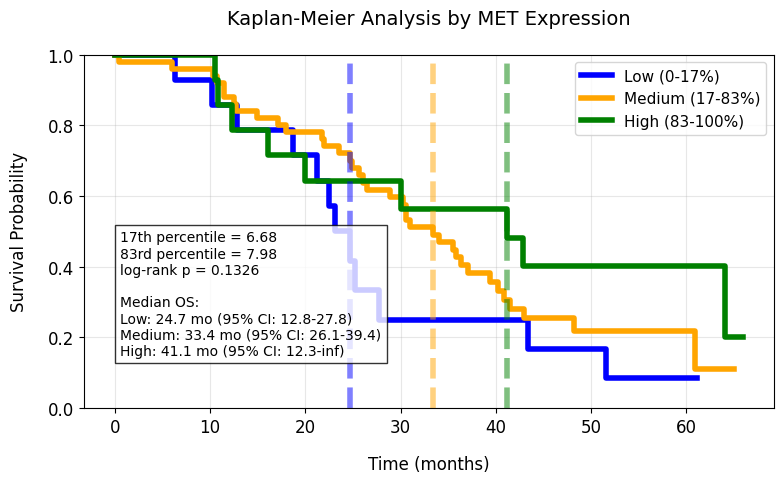


Результаты парных log-rank тестов:
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                test_statistic    p  -log2(p)
High (83-100%) Low (0-17%)                2.26 0.13      2.91
               Medium (17-83%)            0.86 0.35      1.50
Low (0-17%)    Medium (17-83%)            1.70 0.19      2.38

Медианная выживаемость:
Low (0-17%): 24.7 месяцев (95% ДИ: 12.8-27.8)
Medium (17-83%): 33.4 месяцев (95% ДИ: 26.1-39.4)
High (83-100%): 41.1 месяцев (95% ДИ: 12.3-inf)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/filtered_data.csv')

# Конвертация дней в месяцы (1 месяц = 30.44 дней)
data['OS_months'] = data['OS'] / 30.44

# Определение квантилей 17% и 83%
low_q = data['MET'].quantile(0.17)
high_q = data['MET'].quantile(0.83)

# Разделение на 3 группы (изменено Middle на Medium)
data['MET_group'] = np.select(
    [
        data['MET'] <= low_q,
        (data['MET'] > low_q) & (data['MET'] < high_q),
        data['MET'] >= high_q
    ],
    [
        'Low (0-17%)',
        'Medium (17-83%)',  # Changed from Middle to Medium
        'High (83-100%)'
    ]
)

# Настройки стиля (белый фон, черные оси)
plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'lines.linewidth': 4,
    'figure.figsize': (8, 5),
    'axes.edgecolor': 'black',
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

# Kaplan-Meier анализ
fig, ax = plt.subplots()
kmf = KaplanMeierFitter()

# Новая функция для расчета доверительных интервалов медианного времени
def get_median_ci(kmf):
    if kmf.median_survival_time_ is np.inf:
        return (np.inf, np.inf)
    
    # Получаем доверительные интервалы для функции выживаемости
    ci_df = kmf.confidence_interval_survival_function_
    survival_function = kmf.survival_function_
    
    # Находим время, когда нижний ДИ пересекает 0.5
    lower_ci = ci_df.iloc[:, 0]
    lower_median_time = np.inf
    if any(lower_ci <= 0.5):
        lower_median_time = ci_df.index[lower_ci <= 0.5][0]
    
    # Находим время, когда верхний ДИ пересекает 0.5
    upper_ci = ci_df.iloc[:, 1]
    upper_median_time = np.inf
    if any(upper_ci <= 0.5):
        upper_median_time = ci_df.index[upper_ci <= 0.5][0]
    
    return (lower_median_time, upper_median_time)

# Цвета для групп
colors = {
    'Low (0-17%)': 'blue',
    'Medium (17-83%)': 'orange',  # Updated label
    'High (83-100%)': 'green'
}

# Словарь для хранения медианных значений и доверительных интервалов
median_data = {}

# Построение кривых для каждой группы
for group in ['Low (0-17%)', 'Medium (17-83%)', 'High (83-100%)']:  # Updated label
    subset = data[data['MET_group'] == group]
    kmf.fit(subset['OS_months'], subset['OS_FLAG'], label=group)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=colors[group])
    
    # Сохранение медианных значений с ДИ по времени
    median_time = kmf.median_survival_time_
    ci_lower, ci_upper = get_median_ci(kmf)
    median_data[group] = {
        'median': median_time,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

# Парные log-rank тесты
results = pairwise_logrank_test(
    data['OS_months'],
    data['MET_group'],
    data['OS_FLAG']
)

# Оформление графика
ax.set_title('Kaplan-Meier Analysis by MET Expression', pad=22)
ax.set_xlabel('Time (months)', labelpad=14)
ax.set_ylabel('Survival Probability', labelpad=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

# Добавление статистики (обновлены названия групп)
stats_text = f"""17th percentile = {low_q:.2f}
83rd percentile = {high_q:.2f}
log-rank p = {results.p_value.min():.4f}

Median OS:
Low: {median_data['Low (0-17%)']['median']:.1f} mo (95% CI: {median_data['Low (0-17%)']['ci_lower']:.1f}-{median_data['Low (0-17%)']['ci_upper']:.1f})
Medium: {median_data['Medium (17-83%)']['median']:.1f} mo (95% CI: {median_data['Medium (17-83%)']['ci_lower']:.1f}-{median_data['Medium (17-83%)']['ci_upper']:.1f})
High: {median_data['High (83-100%)']['median']:.1f} mo (95% CI: {median_data['High (83-100%)']['ci_lower']:.1f}-{median_data['High (83-100%)']['ci_upper']:.1f})"""

ax.text(0.55, 0.15, stats_text, 
        bbox=dict(facecolor='white', alpha=0.8),
        fontsize=10)

# Легенда
ax.legend(frameon=True, framealpha=0.8, loc='upper right')

# Добавление вертикальных линий для медианной выживаемости
for group in ['Low (0-17%)', 'Medium (17-83%)', 'High (83-100%)']:  # Updated label
    median_time = median_data[group]['median']
    if median_time != np.inf:
        plt.axvline(x=median_time, color=colors[group], linestyle='--', alpha=0.5)

plt.tight_layout()

# Сохранение результатов
output_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_3_groups.csv'
data.to_csv(output_path, index=False)
plt.savefig('MET_3_groups_KM_with_median.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nГрафик сохранен как MET_3_groups_KM_with_median.png")
print(f"Данные с группами сохранены: {output_path}")

plt.show()

# Вывод результатов (обновлены названия групп)
print("\nРезультаты парных log-rank тестов:")
print(results)

print("\nМедианная выживаемость:")
for group in median_data:
    print(f"{group}: {median_data[group]['median']:.1f} месяцев (95% ДИ: {median_data[group]['ci_lower']:.1f}-{median_data[group]['ci_upper']:.1f})")

Медиана MET: 7.45
Распределение пациентов:
MET_group
High    39
Low     39
Name: count, dtype: int64

График сохранен как MET_KM_analysis_months.png
Данные с группами сохранены: /mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv


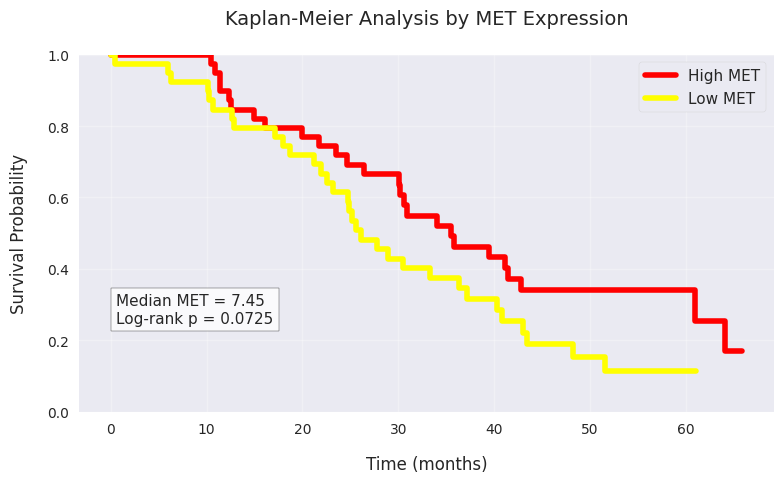

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/filtered_data.csv')

# Конвертация дней в месяцы (1 месяц = 30.44 дней)
data['OS_months'] = data['OS'] / 30.44

# Выбор конечной точки
time_col = 'OS_months'  # Используем месяцы вместо дней
event_col = 'OS_FLAG'

# 1. Разделение по уровню MET
median_met = data['MET'].median()
data['MET_group'] = ['High' if x > median_met else 'Low' for x in data['MET']]

print(f"Медиана MET: {median_met:.2f}")
print("Распределение пациентов:")
print(data['MET_group'].value_counts())

# 2. Настройки стиля
plt.rcParams.update({
    'lines.linewidth': 4,  # Более толстые линии
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 11
})

# Kaplan-Meier анализ
plt.figure(figsize=(8, 5))
kmf = KaplanMeierFitter()

# Для группы с высоким MET
high_met = data[data['MET_group'] == 'High']
kmf.fit(high_met[time_col], high_met[event_col], label='High MET')
ax = kmf.plot_survival_function(ci_show=False, color='red')  # Красный для High MET

# Для группы с низким MET
low_met = data[data['MET_group'] == 'Low']
kmf.fit(low_met[time_col], low_met[event_col], label='Low MET')
kmf.plot_survival_function(ax=ax, ci_show=False, color='yellow')  # Yellow для Low MET

# 3. Log-rank тест
results = logrank_test(
    high_met[time_col], 
    low_met[time_col],
    event_observed_A=high_met[event_col],
    event_observed_B=low_met[event_col]
)

# 4. Оформление графика
plt.title('Kaplan-Meier Analysis by MET Expression', pad=22)
plt.xlabel('Time (months)', labelpad=14)  # Указываем месяцы
plt.ylabel('Survival Probability', labelpad=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Добавление статистики
stats_text = f"""Median MET = {median_met:.2f}
Log-rank p = {results.p_value:.4f}"""
plt.text(0.6, 0.25, stats_text, 
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=11)

# Улучшенная легенда
plt.legend(frameon=True, framealpha=0.8)

plt.tight_layout()

# 5. Сохранение
output_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv'
data.to_csv(output_path, index=False)
plt.savefig('MET_KM_analysis_months.png', dpi=300, bbox_inches='tight')
print(f"\nГрафик сохранен как MET_KM_analysis_months.png")
print(f"Данные с группами сохранены: {output_path}")

plt.show()

Медиана MET: 7.45
Распределение пациентов:
MET_group
High    39
Low     39
Name: count, dtype: int64

График сохранен как MET_KM_analysis_with_median.png
Данные с группами сохранены: /mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv


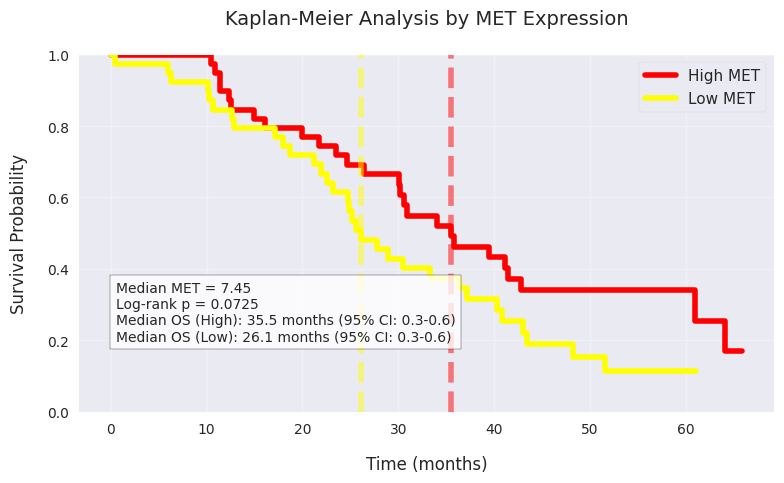


Медианная выживаемость:
High MET: 35.5 месяцев (95% ДИ: 0.3-0.6)
Low MET: 26.1 месяцев (95% ДИ: 0.3-0.6)


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/filtered_data.csv')

# Конвертация дней в месяцы (1 месяц = 30.44 дней)
data['OS_months'] = data['OS'] / 30.44

# Выбор конечной точки
time_col = 'OS_months'
event_col = 'OS_FLAG'

# 1. Разделение по уровню MET
median_met = data['MET'].median()
data['MET_group'] = ['High' if x > median_met else 'Low' for x in data['MET']]

print(f"Медиана MET: {median_met:.2f}")
print("Распределение пациентов:")
print(data['MET_group'].value_counts())

# 2. Настройки стиля
plt.rcParams.update({
    'lines.linewidth': 4,
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 11
})

# Kaplan-Meier анализ
plt.figure(figsize=(8, 5))
kmf = KaplanMeierFitter()

# Новая улучшенная функция для расчета доверительных интервалов медианы
def get_median_ci(kmf):
    if kmf.median_survival_time_ is np.inf:
        return (np.inf, np.inf)
    
    # Получаем все доверительные интервалы
    ci_df = kmf.confidence_interval_
    
    # Преобразуем индекс в числовой массив
    times = ci_df.index.values
    median_time = kmf.median_survival_time_
    
    # Находим индекс ближайшей точки
    closest_idx = np.argmin(np.abs(times - median_time))
    
    # Возвращаем нижний и верхний доверительные интервалы
    return (ci_df.iloc[closest_idx, 0], ci_df.iloc[closest_idx, 1])

# Для группы с высоким MET
high_met = data[data['MET_group'] == 'High']
kmf.fit(high_met[time_col], high_met[event_col], label='High MET')
ax = kmf.plot_survival_function(ci_show=False, color='red')

# Расчет медианной выживаемости для High MET
median_high = kmf.median_survival_time_
ci_high_lower, ci_high_upper = get_median_ci(kmf)

# Для группы с низким MET
low_met = data[data['MET_group'] == 'Low']
kmf.fit(low_met[time_col], low_met[event_col], label='Low MET')
kmf.plot_survival_function(ax=ax, ci_show=False, color='yellow')

# Расчет медианной выживаемости для Low MET
median_low = kmf.median_survival_time_
ci_low_lower, ci_low_upper = get_median_ci(kmf)

# 3. Log-rank тест
results = logrank_test(
    high_met[time_col], 
    low_met[time_col],
    event_observed_A=high_met[event_col],
    event_observed_B=low_met[event_col]
)

# 4. Оформление графика
plt.title('Kaplan-Meier Analysis by MET Expression', pad=22)
plt.xlabel('Time (months)', labelpad=14)
plt.ylabel('Survival Probability', labelpad=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Добавление статистики
stats_text = f"""Median MET = {median_met:.2f}
Log-rank p = {results.p_value:.4f}
Median OS (High): {median_high:.1f} months (95% CI: {ci_high_lower:.1f}-{ci_high_upper:.1f})
Median OS (Low): {median_low:.1f} months (95% CI: {ci_low_lower:.1f}-{ci_low_upper:.1f})"""
plt.text(0.55, 0.2, stats_text, 
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=10)

# Улучшенная легенда
plt.legend(frameon=True, framealpha=0.8, loc='upper right')

# Добавление вертикальных линий для медианной выживаемости
if median_high != np.inf:
    plt.axvline(x=median_high, color='red', linestyle='--', alpha=0.5)
if median_low != np.inf:
    plt.axvline(x=median_low, color='yellow', linestyle='--', alpha=0.5)

plt.tight_layout()

# 5. Сохранение
output_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv'
data.to_csv(output_path, index=False)
plt.savefig('MET_KM_analysis_with_median.png', dpi=300, bbox_inches='tight')
print(f"\nГрафик сохранен как MET_KM_analysis_with_median.png")
print(f"Данные с группами сохранены: {output_path}")

plt.show()

# Вывод медианных значений
print("\nМедианная выживаемость:")
print(f"High MET: {median_high:.1f} месяцев (95% ДИ: {ci_high_lower:.1f}-{ci_high_upper:.1f})")
print(f"Low MET: {median_low:.1f} месяцев (95% ДИ: {ci_low_lower:.1f}-{ci_low_upper:.1f})")

Медиана MET: 7.45
Распределение пациентов:
MET_group
High    39
Low     39
Name: count, dtype: int64

График сохранен как MET_KM_analysis_with_median.png
Данные с группами сохранены: /mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv


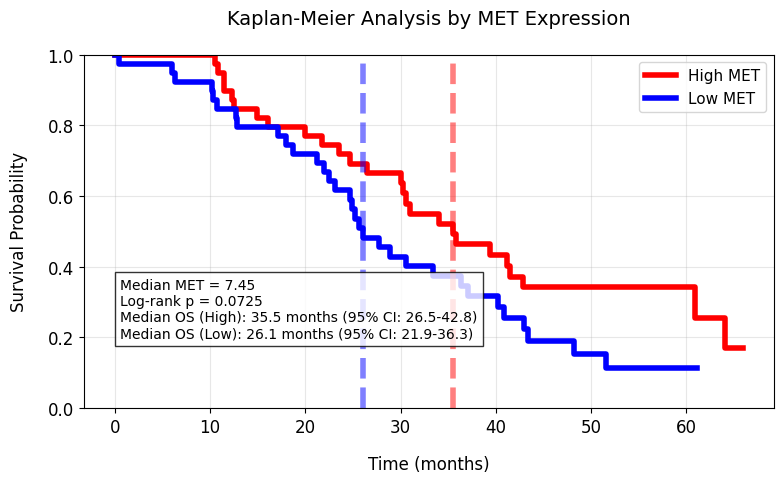


Медианная выживаемость:
High MET: 35.5 месяцев (95% ДИ: 26.5-42.8)
Low MET: 26.1 месяцев (95% ДИ: 21.9-36.3)


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np

# Загрузка данных
data = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/filtered_data.csv')

# Конвертация дней в месяцы (1 месяц = 30.44 дней)
data['OS_months'] = data['OS'] / 30.44

# Выбор конечной точки
time_col = 'OS_months'
event_col = 'OS_FLAG'

# 1. Разделение по уровню MET
median_met = data['MET'].median()
data['MET_group'] = ['High' if x > median_met else 'Low' for x in data['MET']]

print(f"Медиана MET: {median_met:.2f}")
print("Распределение пациентов:")
print(data['MET_group'].value_counts())

# 2. Настройки стиля
plt.style.use('default')
plt.rcParams.update({
    'lines.linewidth': 4,
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'axes.edgecolor': 'black',
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

# Kaplan-Meier анализ
plt.figure(figsize=(8, 5))
kmf = KaplanMeierFitter()

# Функция для расчета доверительных интервалов медианного времени
def get_median_ci(kmf):
    if kmf.median_survival_time_ is np.inf:
        return (np.inf, np.inf)
    
    # Получаем доверительные интервалы для времени
    ci_df = kmf.confidence_interval_survival_function_
    
    # Находим время, соответствующее 50% выживаемости
    survival_function = kmf.survival_function_
    median_time = kmf.median_survival_time_
    
    # Находим ближайшие точки для нижнего и верхнего ДИ
    lower_ci = ci_df.iloc[:, 0]
    upper_ci = ci_df.iloc[:, 1]
    
    # Находим время, когда нижний ДИ пересекает 0.5
    lower_median_time = np.inf
    if any(lower_ci <= 0.5):
        lower_median_time = ci_df.index[lower_ci <= 0.5][0]
    
    # Находим время, когда верхний ДИ пересекает 0.5
    upper_median_time = np.inf
    if any(upper_ci <= 0.5):
        upper_median_time = ci_df.index[upper_ci <= 0.5][0]
    
    return (lower_median_time, upper_median_time)

# Для группы с высоким MET
high_met = data[data['MET_group'] == 'High']
kmf.fit(high_met[time_col], high_met[event_col], label='High MET')
ax = kmf.plot_survival_function(ci_show=False, color='red')

# Расчет медианной выживаемости для High MET
median_high = kmf.median_survival_time_
ci_high_lower, ci_high_upper = get_median_ci(kmf)

# Для группы с низким MET
low_met = data[data['MET_group'] == 'Low']
kmf.fit(low_met[time_col], low_met[event_col], label='Low MET')
kmf.plot_survival_function(ax=ax, ci_show=False, color='blue')  # Changed yellow to blue for better visibility

# Расчет медианной выживаемости для Low MET
median_low = kmf.median_survival_time_
ci_low_lower, ci_low_upper = get_median_ci(kmf)

# 3. Log-rank тест
results = logrank_test(
    high_met[time_col], 
    low_met[time_col],
    event_observed_A=high_met[event_col],
    event_observed_B=low_met[event_col]
)

# 4. Оформление графика
plt.title('Kaplan-Meier Analysis by MET Expression', pad=22)
plt.xlabel('Time (months)', labelpad=14)
plt.ylabel('Survival Probability', labelpad=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Добавление статистики
stats_text = f"""Median MET = {median_met:.2f}
Log-rank p = {results.p_value:.4f}
Median OS (High): {median_high:.1f} months (95% CI: {ci_high_lower:.1f}-{ci_high_upper:.1f})
Median OS (Low): {median_low:.1f} months (95% CI: {ci_low_lower:.1f}-{ci_low_upper:.1f})"""
plt.text(0.55, 0.2, stats_text, 
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=10)

# Улучшенная легенда
plt.legend(frameon=True, framealpha=0.8, loc='upper right')

# Добавление вертикальных линий для медианной выживаемости
if median_high != np.inf:
    plt.axvline(x=median_high, color='red', linestyle='--', alpha=0.5)
if median_low != np.inf:
    plt.axvline(x=median_low, color='blue', linestyle='--', alpha=0.5)

plt.tight_layout()

# 5. Сохранение
output_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/notebooks/filtered_data_with_groups.csv'
data.to_csv(output_path, index=False)
plt.savefig('MET_KM_analysis_with_median.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nГрафик сохранен как MET_KM_analysis_with_median.png")
print(f"Данные с группами сохранены: {output_path}")

plt.show()

# Вывод медианных значений
print("\nМедианная выживаемость:")
print(f"High MET: {median_high:.1f} месяцев (95% ДИ: {ci_high_lower:.1f}-{ci_high_upper:.1f})")
print(f"Low MET: {median_low:.1f} месяцев (95% ДИ: {ci_low_lower:.1f}-{ci_low_upper:.1f})")

Размер объединенных данных: (119, 20090)

Первые 5 пациентов:
  Patient           OS         PFS
0  SAAAGV  1398.926851  283.782304
1  SAAAUS   667.487954  269.793035
2  SAABBH  1015.221200  342.737078
3  SAABLP  1035.205869  240.815265
4  SAABMZ    29.977004   21.983136
All Patients: Медиана OS = 30.1 мес
All Patients: Медиана PFS = 11.7 мес


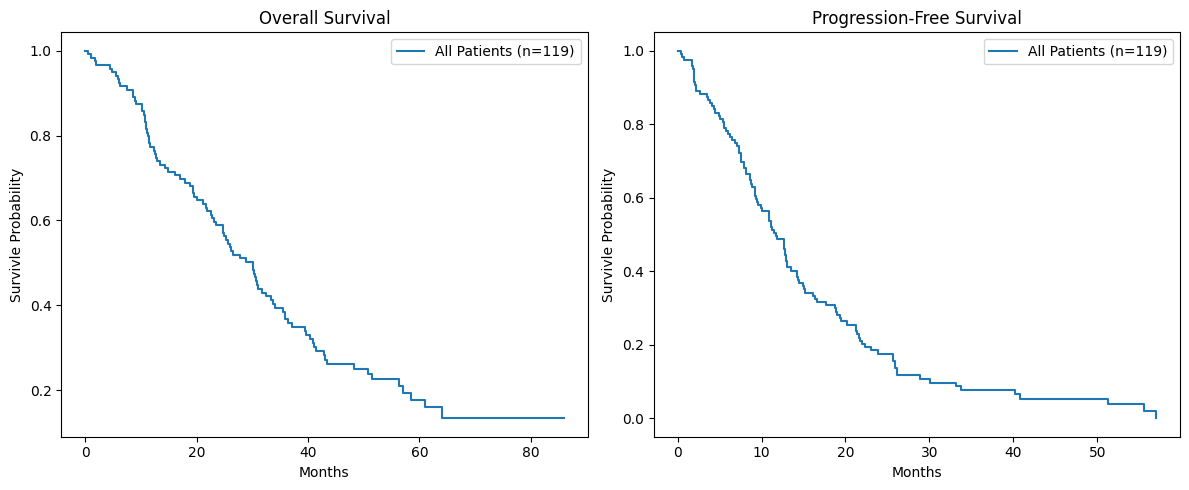

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Загрузка данных
annotation = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/raw/ann_PRJNA805525.csv')
expression = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/cohort_2_expr_ann_emt_signatures.csv')

# Убедимся, что количество строк совпадает
assert len(annotation) == len(expression), "Количество пациентов в файлах различается!"

# Объединение по индексу (порядку строк)
data = pd.concat([
    annotation.reset_index(drop=True), 
    expression.reset_index(drop=True).drop(columns=['sample_id'])  # Удаляем старый ID
], axis=1)

# Проверка
print(f"Размер объединенных данных: {data.shape}")
print("\nПервые 5 пациентов:")
print(data[['Patient', 'OS', 'PFS']].head())

# Конвертация времени
data['OS_months'] = data['OS'] / 30.44  # Дни в месяцы
data['PFS_months'] = data['PFS'] / 30.44

# Создание групп (пример для EMT_score)
if 'EMT_score' in data.columns:
    data['Group'] = np.where(data['EMT_score'] > data['EMT_score'].median(), 
                           'High EMT', 'Low EMT')
    print("\nРаспределение по группам:")
    print(data['Group'].value_counts())
else:
    data['Group'] = 'All Patients'

# Визуализация
plt.figure(figsize=(12, 5))

# 1. Overall Survival
plt.subplot(1, 2, 1)
kmf = KaplanMeierFitter()

for name, group in data.groupby('Group'):
    kmf.fit(group['OS_months'], group['OS_FLAG'], label=f"{name} (n={len(group)})")
    kmf.plot_survival_function(ci_show=False)
    print(f"{name}: Медиана OS = {kmf.median_survival_time_:.1f} мес")

plt.title('Overall Survival')
plt.xlabel('Months')
plt.ylabel('Survivle Probability')

# 2. Progression-Free Survival
plt.subplot(1, 2, 2)
kmf = KaplanMeierFitter()

for name, group in data.groupby('Group'):
    kmf.fit(group['PFS_months'], group['PFS_FLAG'], label=f"{name} (n={len(group)})")
    kmf.plot_survival_function(ci_show=False)
    print(f"{name}: Медиана PFS = {kmf.median_survival_time_:.1f} мес")

plt.title('Progression-Free Survival')
plt.xlabel('Months')
plt.ylabel('Survivle Probability')

plt.tight_layout()
plt.show()

⚠ EMT_score не найден. Анализируем общую выживаемость.


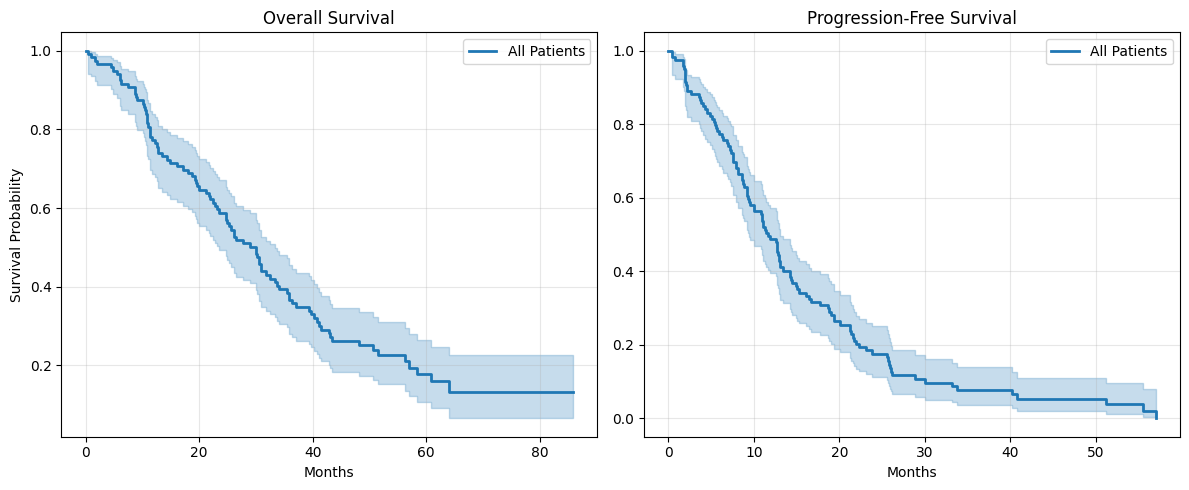


Медианная выживаемость:
All Patients: OS = 30.1 мес | PFS = 11.7 мес


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 1. Загрузка данных
data = pd.concat([
    pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/raw/ann_PRJNA805525.csv'),
    pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/cohort_2_expr_ann_emt_signatures.csv')
], axis=1)

# 2. Проверка EMT_score (если нет — анализируем всю группу)
if 'EMT_score' not in data.columns:
    print("⚠ EMT_score не найден. Анализируем общую выживаемость.")
    data['Group'] = 'All Patients'
else:
    median_emt = data['EMT_score'].median()
    data['Group'] = np.where(data['EMT_score'] > median_emt, 'High EMT', 'Low EMT')

# 3. Конвертация времени в месяцы
data['OS_months'] = data['OS'] / 30.44
data['PFS_months'] = data['PFS'] / 30.44

# 4. Построение Kaplan-Meier
plt.figure(figsize=(12, 5))
kmf = KaplanMeierFitter()

# A. Overall Survival
plt.subplot(1, 2, 1)
for name, group in data.groupby('Group'):
    kmf.fit(group['OS_months'], group['OS_FLAG'], label=name)
    kmf.plot_survival_function(ci_show=True, linewidth=2)
plt.title('Overall Survival')
plt.xlabel('Months')
plt.ylabel('Survival Probability')
plt.grid(True, alpha=0.3)

# B. Progression-Free Survival
plt.subplot(1, 2, 2)
for name, group in data.groupby('Group'):
    kmf.fit(group['PFS_months'], group['PFS_FLAG'], label=name)
    kmf.plot_survival_function(ci_show=True, linewidth=2)
plt.title('Progression-Free Survival')
plt.xlabel('Months')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Вывод медианной выживаемости
print("\nМедианная выживаемость:")
for name, group in data.groupby('Group'):
    kmf.fit(group['OS_months'], group['OS_FLAG'])
    median_os = kmf.median_survival_time_
    kmf.fit(group['PFS_months'], group['PFS_FLAG'])
    median_pfs = kmf.median_survival_time_
    print(f"{name}: OS = {median_os:.1f} мес | PFS = {median_pfs:.1f} мес")

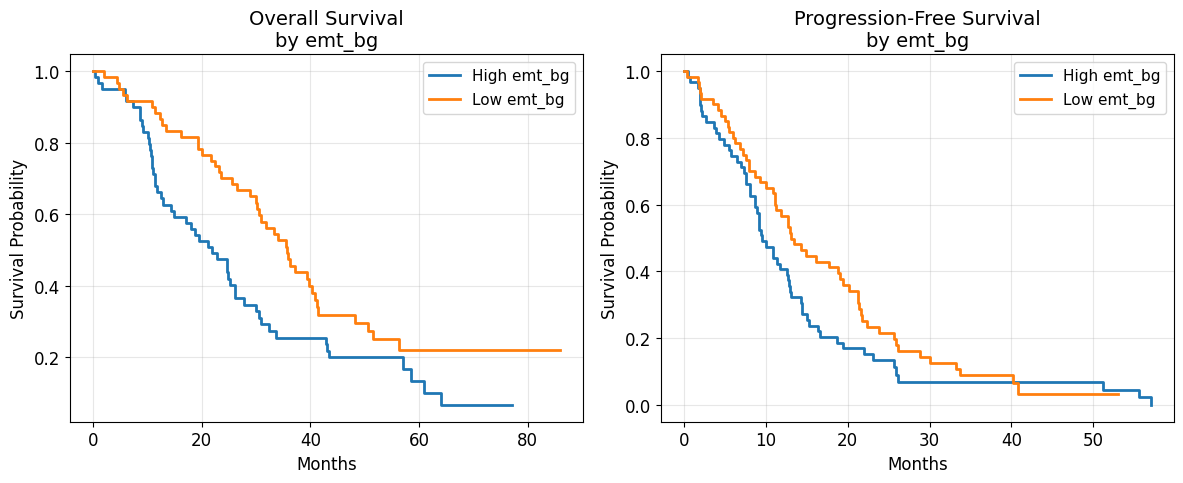


Медианная выживаемость для emt_bg:
High emt_bg: OS = 21.9 мес | PFS = 9.6 мес
Low emt_bg: OS = 35.8 мес | PFS = 13.1 мес


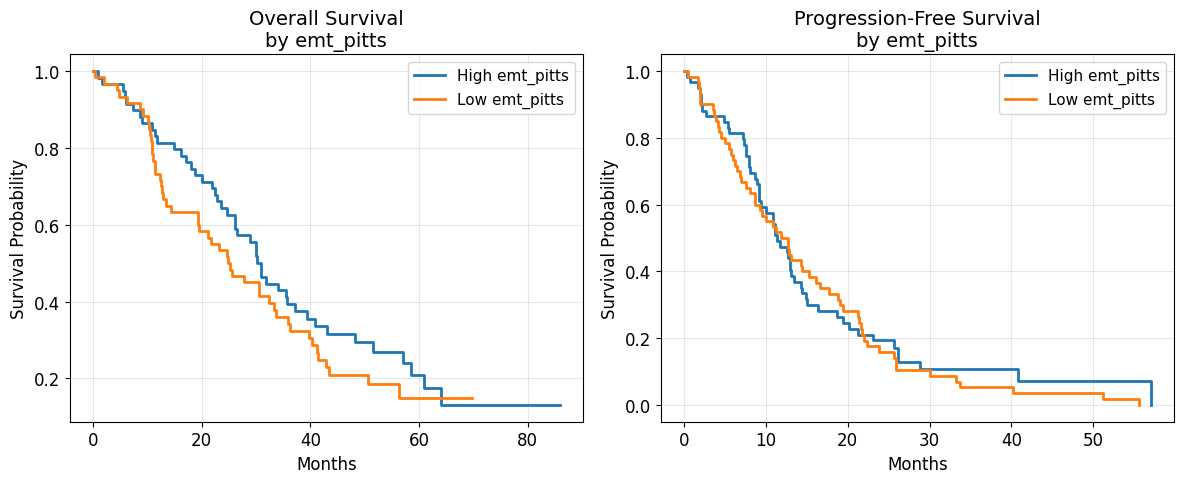


Медианная выживаемость для emt_pitts:
High emt_pitts: OS = 30.9 мес | PFS = 11.4 мес
Low emt_pitts: OS = 25.2 мес | PFS = 12.7 мес


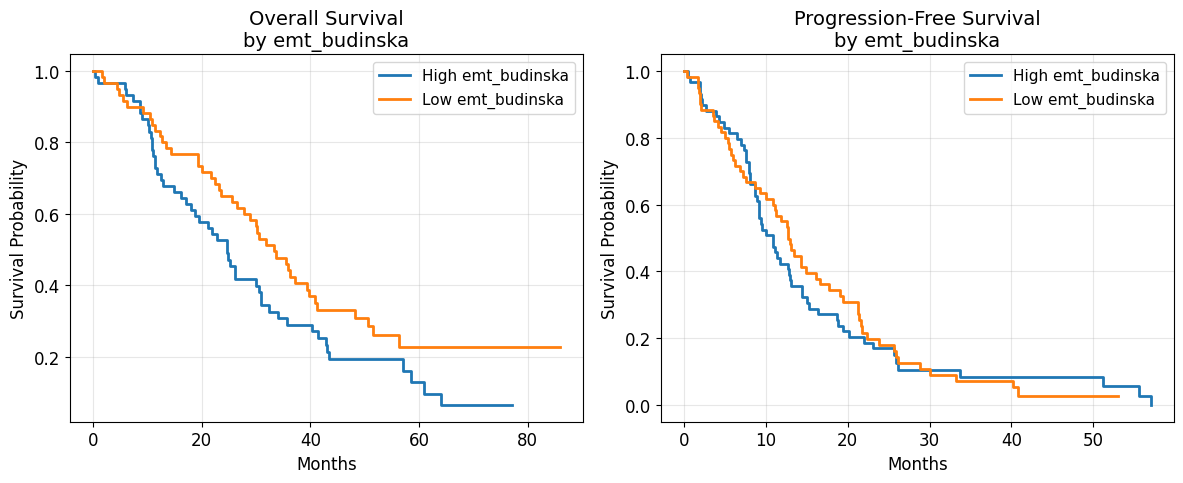


Медианная выживаемость для emt_budinska:
High emt_budinska: OS = 24.7 мес | PFS = 10.9 мес
Low emt_budinska: OS = 33.4 мес | PFS = 12.7 мес


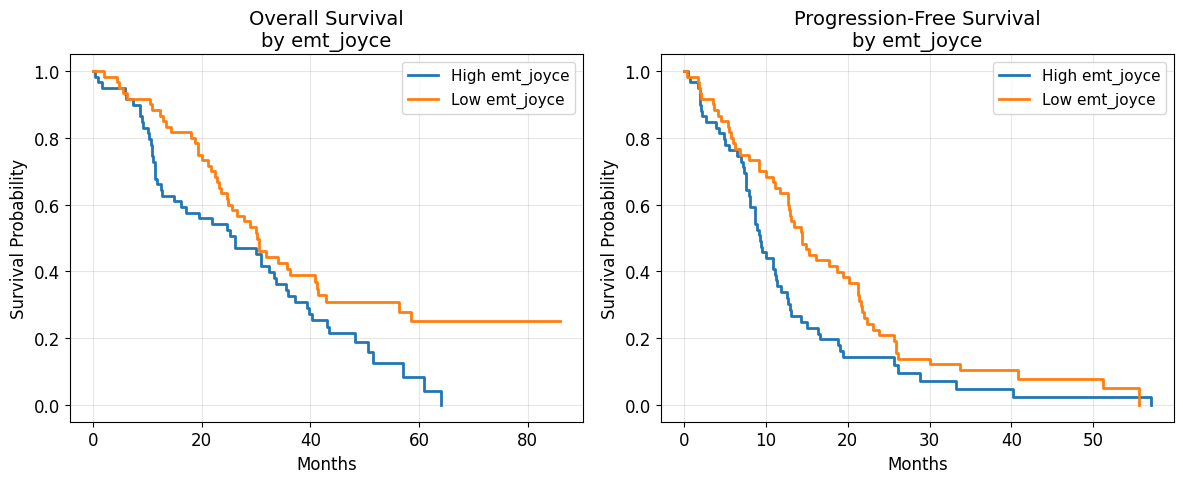


Медианная выживаемость для emt_joyce:
High emt_joyce: OS = 26.1 мес | PFS = 9.3 мес
Low emt_joyce: OS = 30.2 мес | PFS = 14.4 мес


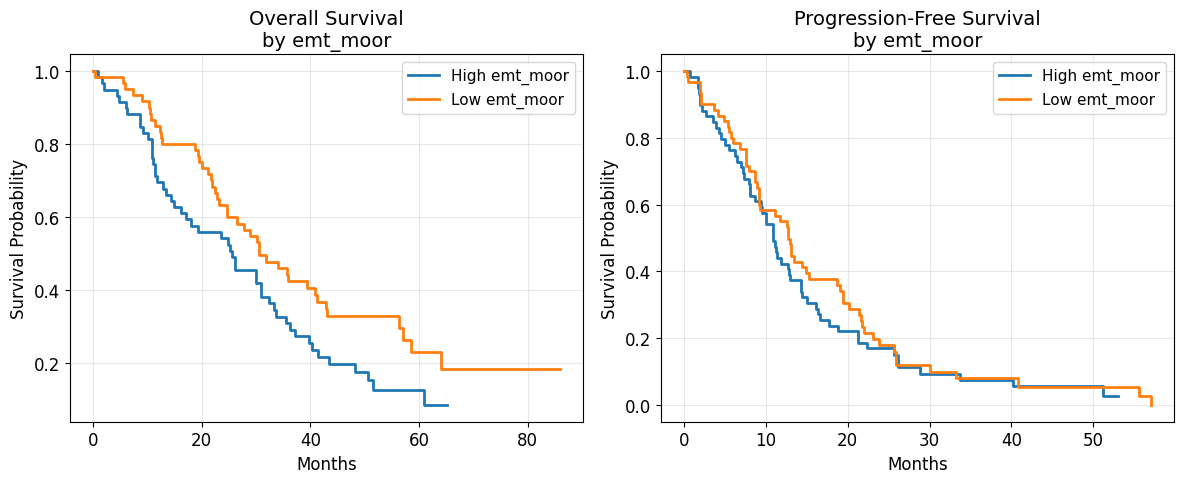


Медианная выживаемость для emt_moor:
High emt_moor: OS = 25.6 мес | PFS = 10.9 мес
Low emt_moor: OS = 30.6 мес | PFS = 12.7 мес


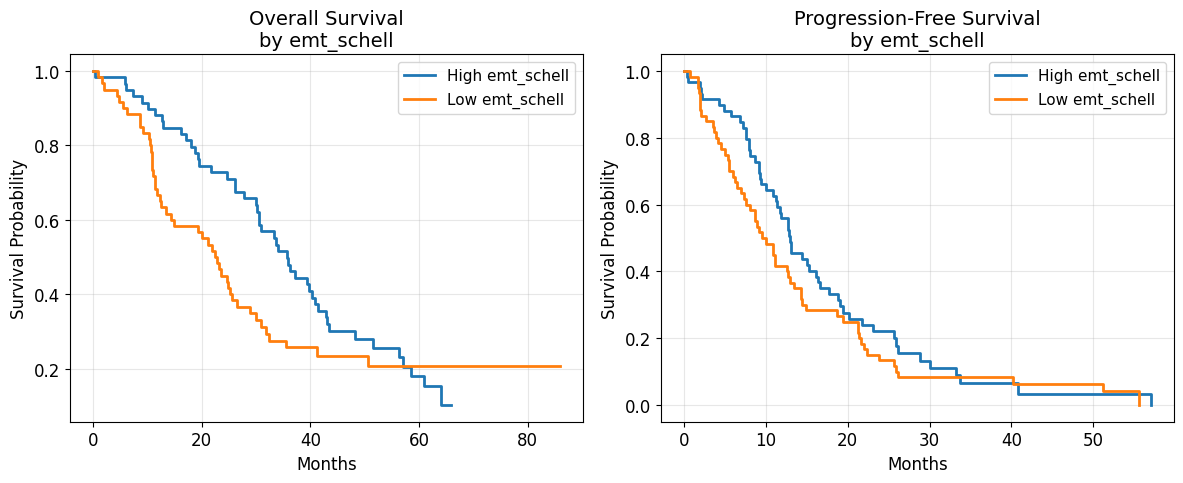


Медианная выживаемость для emt_schell:
High emt_schell: OS = 35.8 мес | PFS = 12.9 мес
Low emt_schell: OS = 22.8 мес | PFS = 10.1 мес


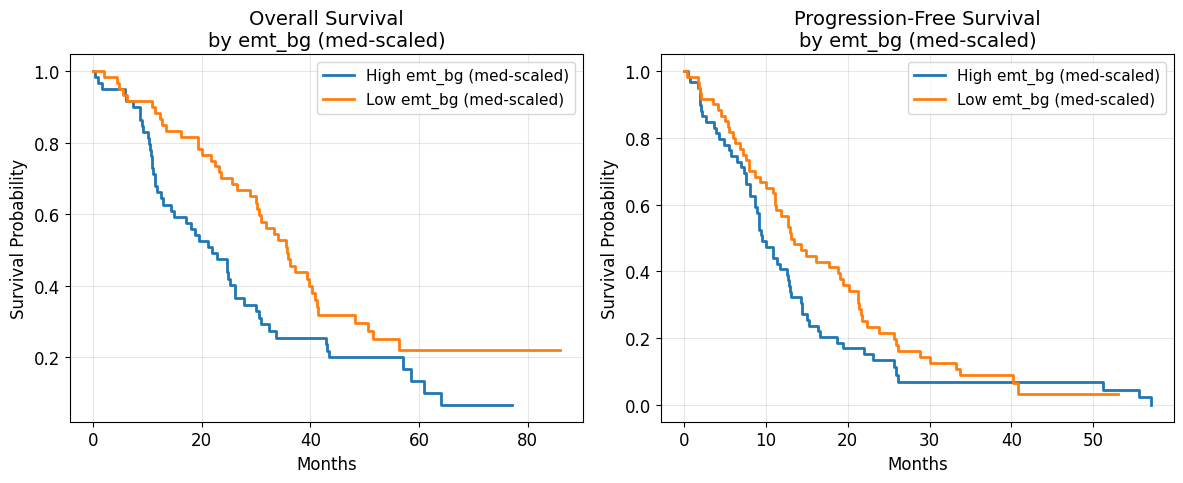


Медианная выживаемость для emt_bg (med-scaled):
High emt_bg (med-scaled): OS = 21.9 мес | PFS = 9.6 мес
Low emt_bg (med-scaled): OS = 35.8 мес | PFS = 13.1 мес


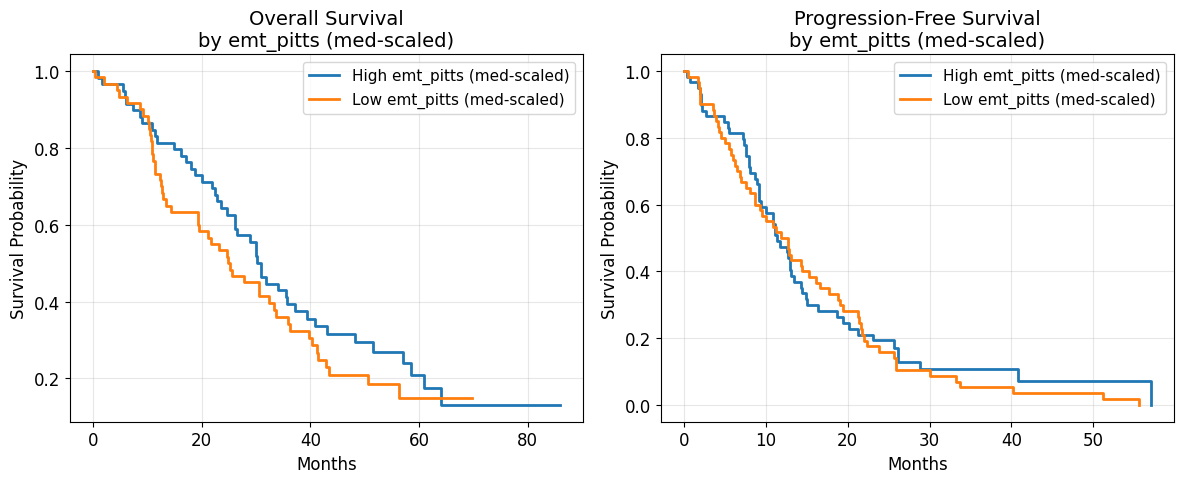


Медианная выживаемость для emt_pitts (med-scaled):
High emt_pitts (med-scaled): OS = 30.9 мес | PFS = 11.4 мес
Low emt_pitts (med-scaled): OS = 25.2 мес | PFS = 12.7 мес


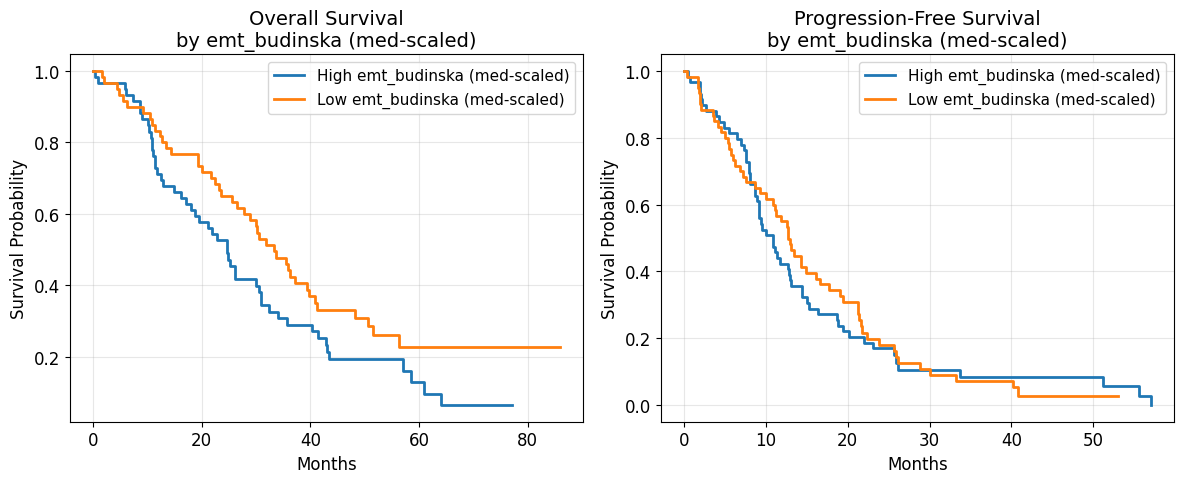


Медианная выживаемость для emt_budinska (med-scaled):
High emt_budinska (med-scaled): OS = 24.7 мес | PFS = 10.9 мес
Low emt_budinska (med-scaled): OS = 33.4 мес | PFS = 12.7 мес


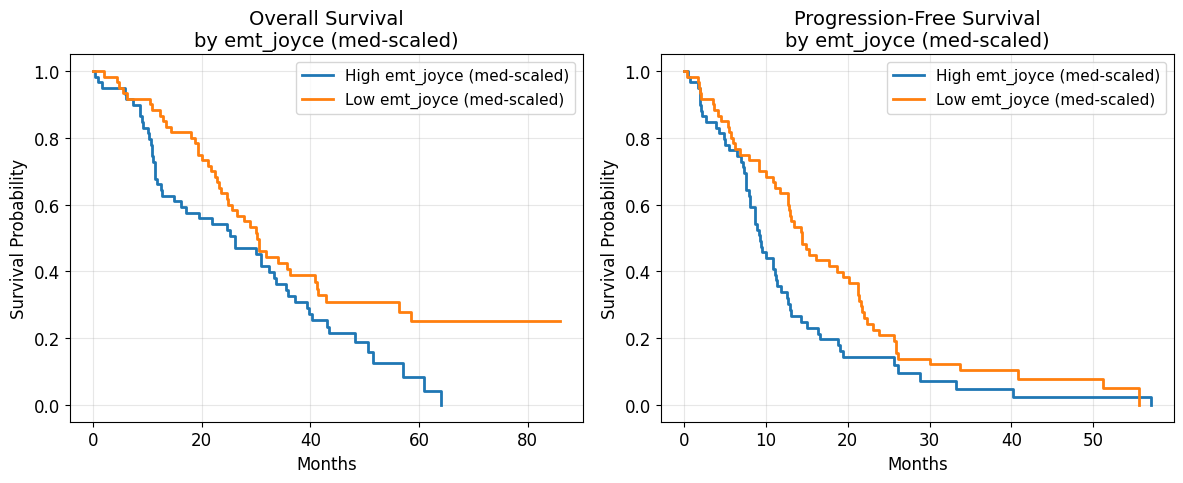


Медианная выживаемость для emt_joyce (med-scaled):
High emt_joyce (med-scaled): OS = 26.1 мес | PFS = 9.3 мес
Low emt_joyce (med-scaled): OS = 30.2 мес | PFS = 14.4 мес


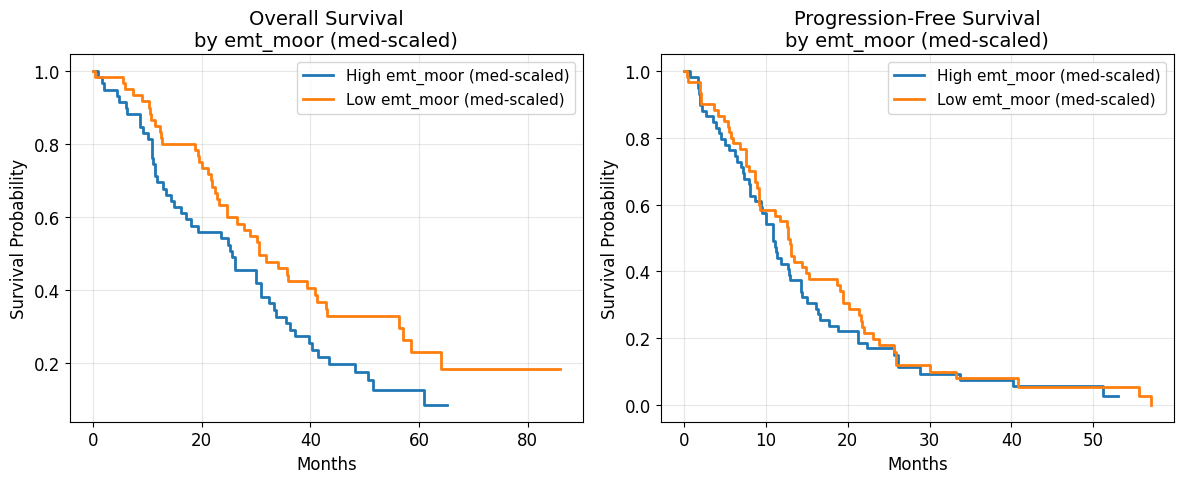


Медианная выживаемость для emt_moor (med-scaled):
High emt_moor (med-scaled): OS = 25.6 мес | PFS = 10.9 мес
Low emt_moor (med-scaled): OS = 30.6 мес | PFS = 12.7 мес


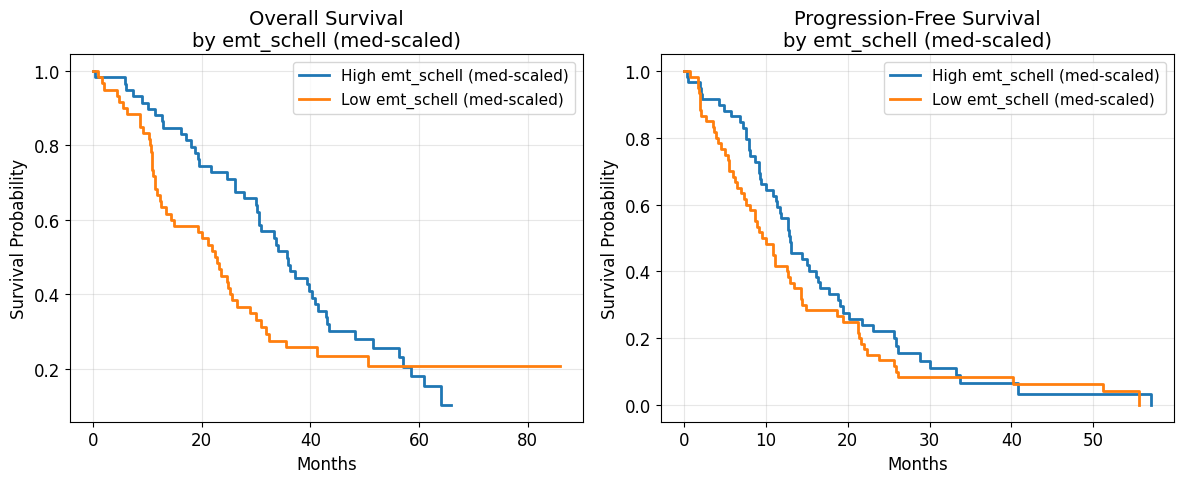


Медианная выживаемость для emt_schell (med-scaled):
High emt_schell (med-scaled): OS = 35.8 мес | PFS = 12.9 мес
Low emt_schell (med-scaled): OS = 22.8 мес | PFS = 10.1 мес


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 1. Загрузка данных
data = pd.concat([
    pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/raw/ann_PRJNA805525.csv'),
    pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/cohort_2_expr_ann_emt_signatures.csv')
], axis=1)

# 2. Конвертация времени в месяцы
data['OS_months'] = data['OS'] / 30.44
data['PFS_months'] = data['PFS'] / 30.44

# 3. Получаем список всех EMT сигнатур
emt_signatures = [col for col in data.columns if col.startswith('EMT_SIGNATURE')]

# 4. Анализ для каждой EMT сигнатуры
for signature in emt_signatures:
    # Создаем фигуру
    plt.figure(figsize=(12, 5))
    kmf = KaplanMeierFitter()
    
    # Убираем префикс и суффикс для названия
    clean_name = signature.replace('EMT_SIGNATURE_', '').replace('_med', ' (med-scaled)')
    
    # Делим пациентов на группы по медиане текущей сигнатуры
    median_value = data[signature].median()
    data['Group'] = np.where(data[signature] > median_value, f'High {clean_name}', f'Low {clean_name}')
    
    # A. Overall Survival
    plt.subplot(1, 2, 1)
    for name, group in data.groupby('Group'):
        kmf.fit(group['OS_months'], group['OS_FLAG'], label=name)
        kmf.plot_survival_function(ci_show=False, linewidth=2)
    plt.title(f'Overall Survival\nby {clean_name}')
    plt.xlabel('Months')
    plt.ylabel('Survival Probability')
    plt.grid(True, alpha=0.3)
    
    # B. Progression-Free Survival
    plt.subplot(1, 2, 2)
    for name, group in data.groupby('Group'):
        kmf.fit(group['PFS_months'], group['PFS_FLAG'], label=name)
        kmf.plot_survival_function(ci_show=False, linewidth=2)
    plt.title(f'Progression-Free Survival\nby {clean_name}')
    plt.xlabel('Months')
    plt.ylabel('Survival Probability')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Вывод медианной выживаемости
    print(f"\nМедианная выживаемость для {clean_name}:")
    for name, group in data.groupby('Group'):
        kmf.fit(group['OS_months'], group['OS_FLAG'])
        median_os = kmf.median_survival_time_
        kmf.fit(group['PFS_months'], group['PFS_FLAG'])
        median_pfs = kmf.median_survival_time_
        print(f"{name}: OS = {median_os:.1f} мес | PFS = {median_pfs:.1f} мес")

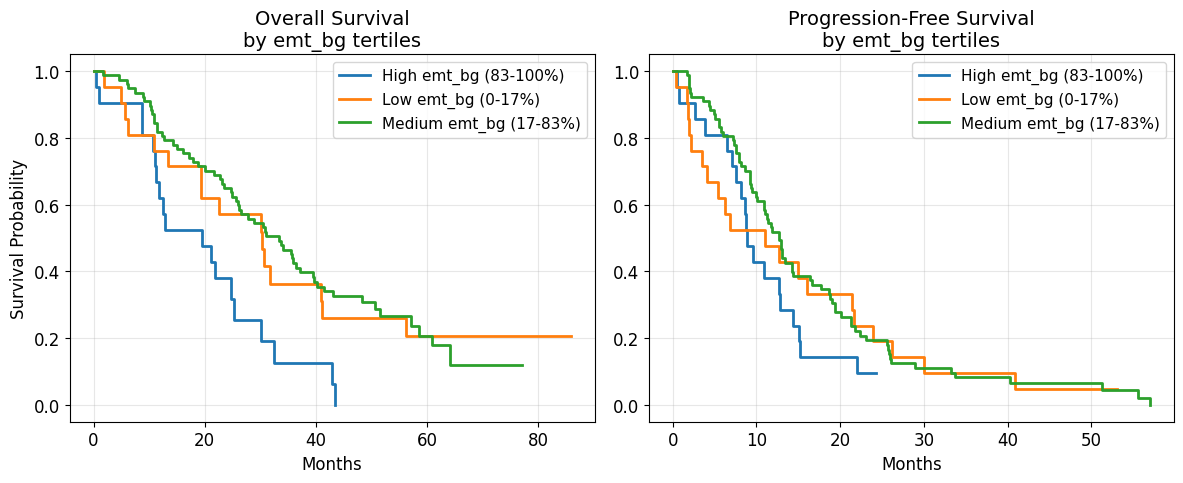


Медианная выживаемость для emt_bg (тертили):
High emt_bg (83-100%): OS = 19.6 мес | PFS = 8.9 мес
Low emt_bg (0-17%): OS = 30.2 мес | PFS = 11.1 мес
Medium emt_bg (17-83%): OS = 33.4 мес | PFS = 12.7 мес


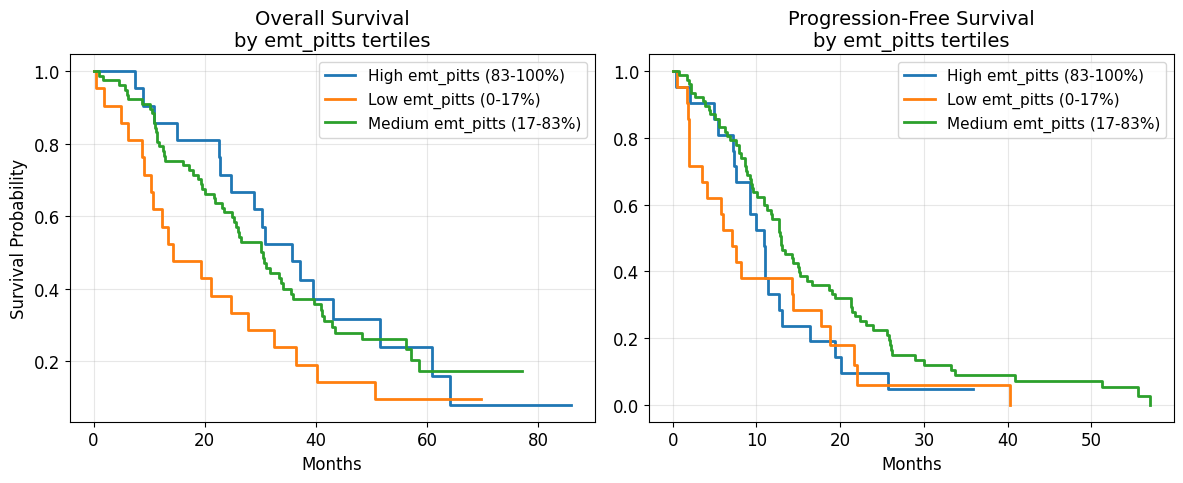


Медианная выживаемость для emt_pitts (тертили):
High emt_pitts (83-100%): OS = 35.8 мес | PFS = 10.9 мес
Low emt_pitts (0-17%): OS = 14.3 мес | PFS = 7.0 мес
Medium emt_pitts (17-83%): OS = 30.5 мес | PFS = 12.9 мес


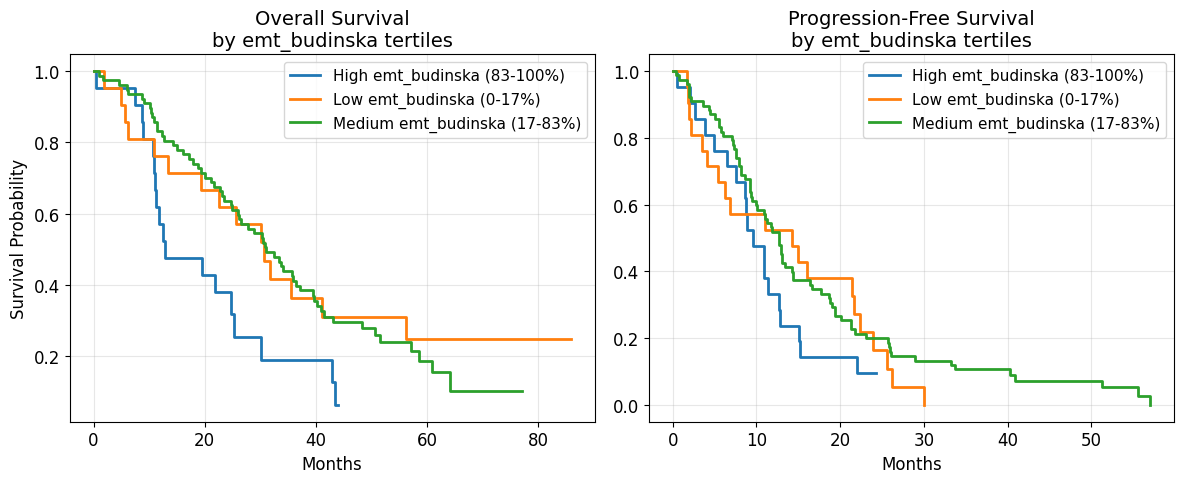


Медианная выживаемость для emt_budinska (тертили):
High emt_budinska (83-100%): OS = 12.8 мес | PFS = 9.6 мес
Low emt_budinska (0-17%): OS = 30.6 мес | PFS = 14.2 мес
Medium emt_budinska (17-83%): OS = 31.0 мес | PFS = 12.7 мес


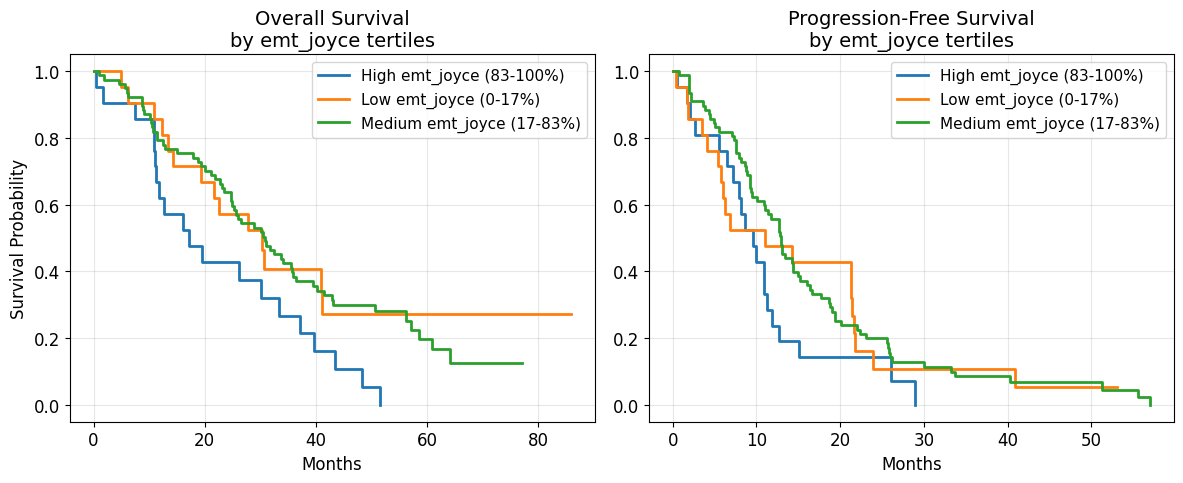


Медианная выживаемость для emt_joyce (тертили):
High emt_joyce (83-100%): OS = 17.1 мес | PFS = 9.6 мес
Low emt_joyce (0-17%): OS = 30.2 мес | PFS = 11.1 мес
Medium emt_joyce (17-83%): OS = 30.9 мес | PFS = 12.9 мес


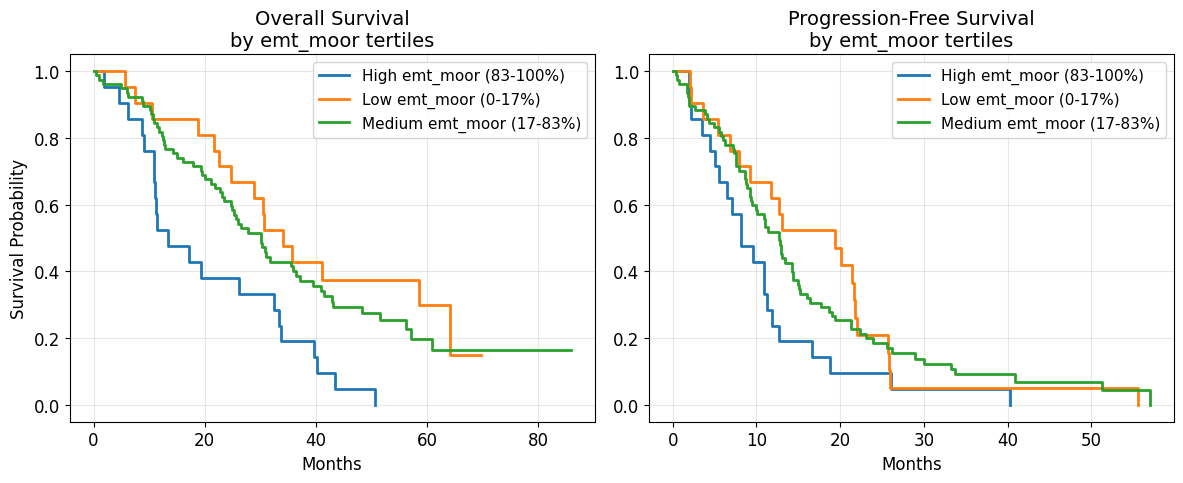


Медианная выживаемость для emt_moor (тертили):
High emt_moor (83-100%): OS = 13.5 мес | PFS = 8.1 мес
Low emt_moor (0-17%): OS = 34.0 мес | PFS = 19.4 мес
Medium emt_moor (17-83%): OS = 30.1 мес | PFS = 12.7 мес


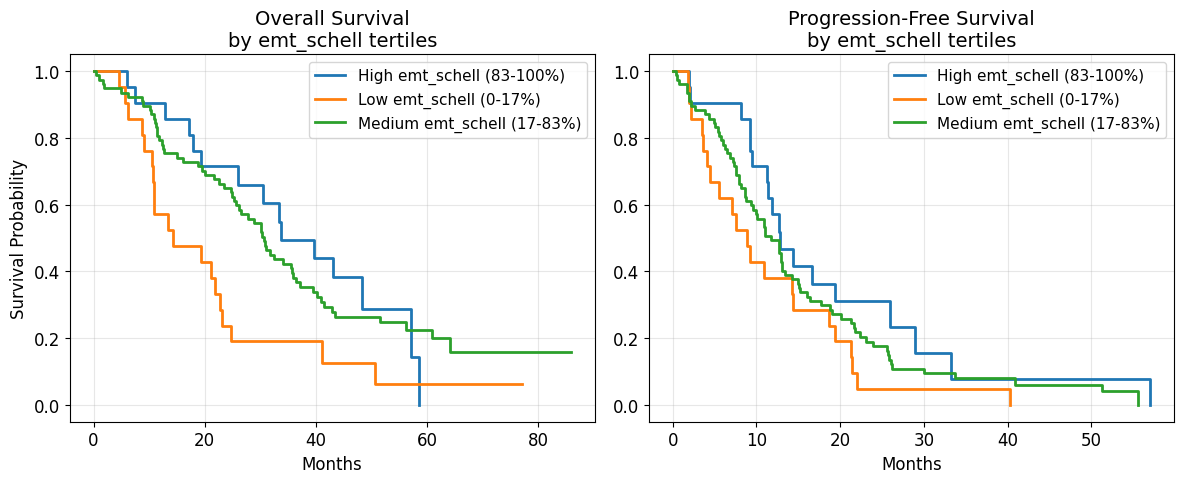


Медианная выживаемость для emt_schell (тертили):
High emt_schell (83-100%): OS = 33.7 мес | PFS = 12.8 мес
Low emt_schell (0-17%): OS = 14.3 мес | PFS = 8.9 мес
Medium emt_schell (17-83%): OS = 30.6 мес | PFS = 11.7 мес


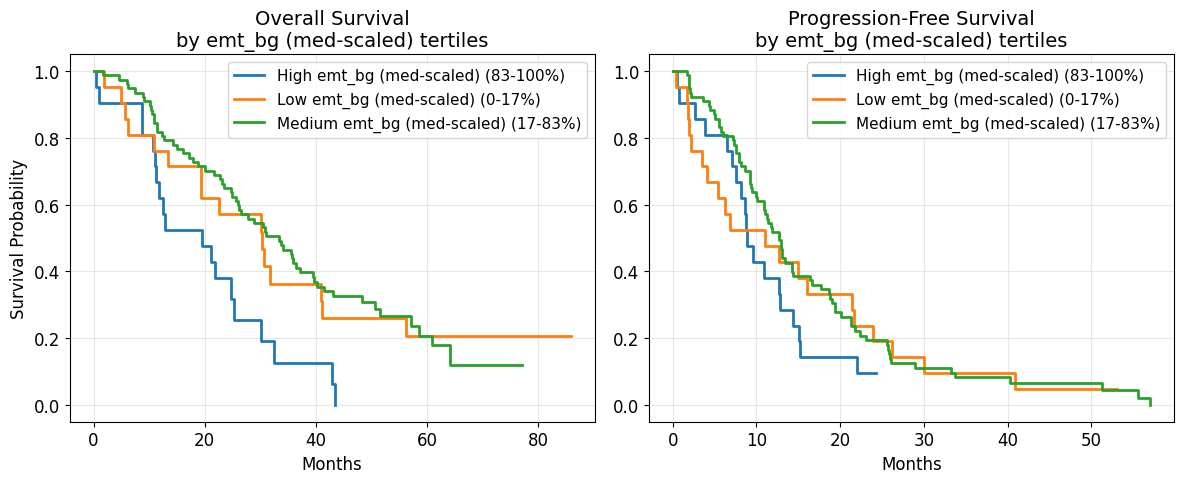


Медианная выживаемость для emt_bg (med-scaled) (тертили):
High emt_bg (med-scaled) (83-100%): OS = 19.6 мес | PFS = 8.9 мес
Low emt_bg (med-scaled) (0-17%): OS = 30.2 мес | PFS = 11.1 мес
Medium emt_bg (med-scaled) (17-83%): OS = 33.4 мес | PFS = 12.7 мес


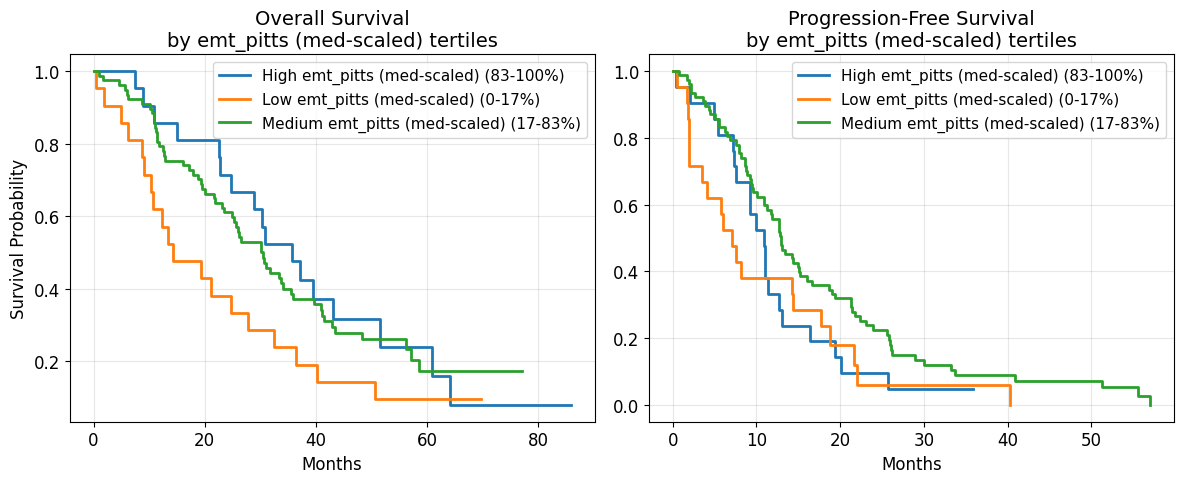


Медианная выживаемость для emt_pitts (med-scaled) (тертили):
High emt_pitts (med-scaled) (83-100%): OS = 35.8 мес | PFS = 10.9 мес
Low emt_pitts (med-scaled) (0-17%): OS = 14.3 мес | PFS = 7.0 мес
Medium emt_pitts (med-scaled) (17-83%): OS = 30.5 мес | PFS = 12.9 мес


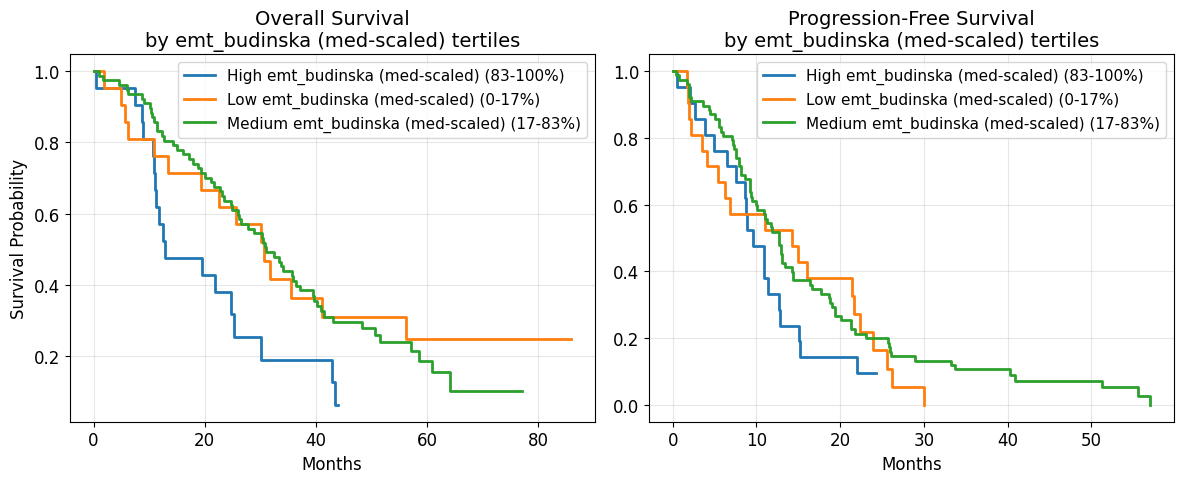


Медианная выживаемость для emt_budinska (med-scaled) (тертили):
High emt_budinska (med-scaled) (83-100%): OS = 12.8 мес | PFS = 9.6 мес
Low emt_budinska (med-scaled) (0-17%): OS = 30.6 мес | PFS = 14.2 мес
Medium emt_budinska (med-scaled) (17-83%): OS = 31.0 мес | PFS = 12.7 мес


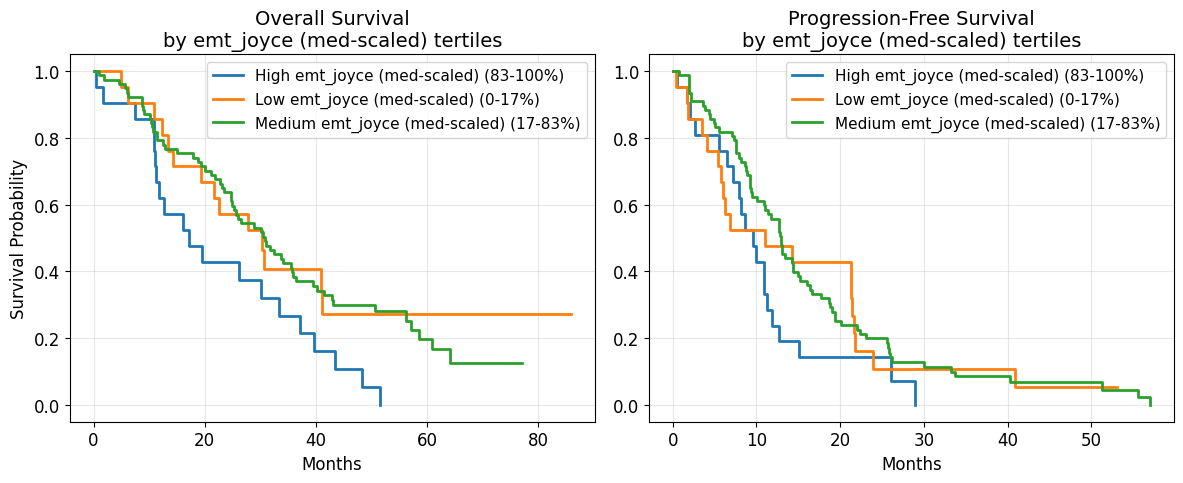


Медианная выживаемость для emt_joyce (med-scaled) (тертили):
High emt_joyce (med-scaled) (83-100%): OS = 17.1 мес | PFS = 9.6 мес
Low emt_joyce (med-scaled) (0-17%): OS = 30.2 мес | PFS = 11.1 мес
Medium emt_joyce (med-scaled) (17-83%): OS = 30.9 мес | PFS = 12.9 мес


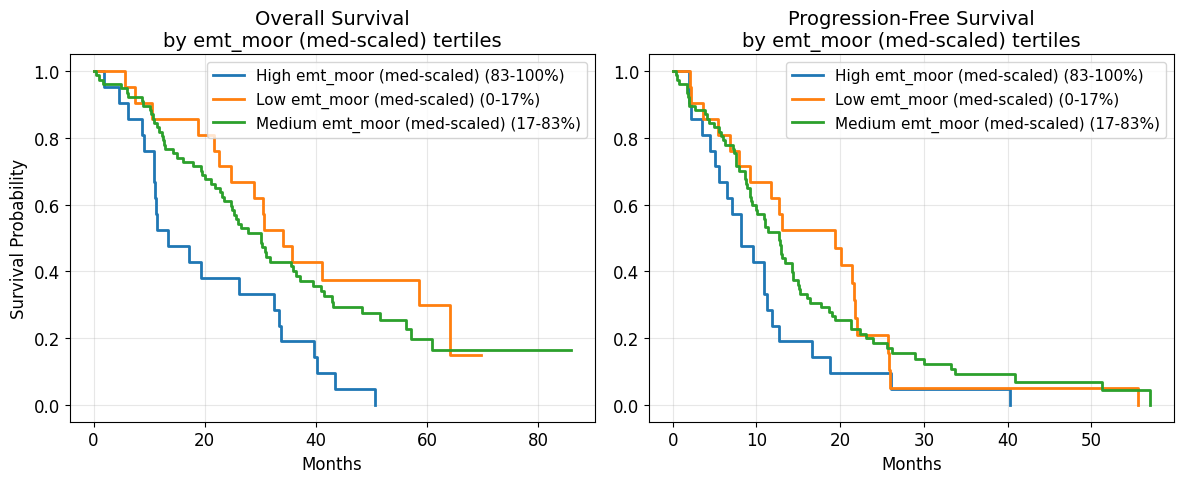


Медианная выживаемость для emt_moor (med-scaled) (тертили):
High emt_moor (med-scaled) (83-100%): OS = 13.5 мес | PFS = 8.1 мес
Low emt_moor (med-scaled) (0-17%): OS = 34.0 мес | PFS = 19.4 мес
Medium emt_moor (med-scaled) (17-83%): OS = 30.1 мес | PFS = 12.7 мес


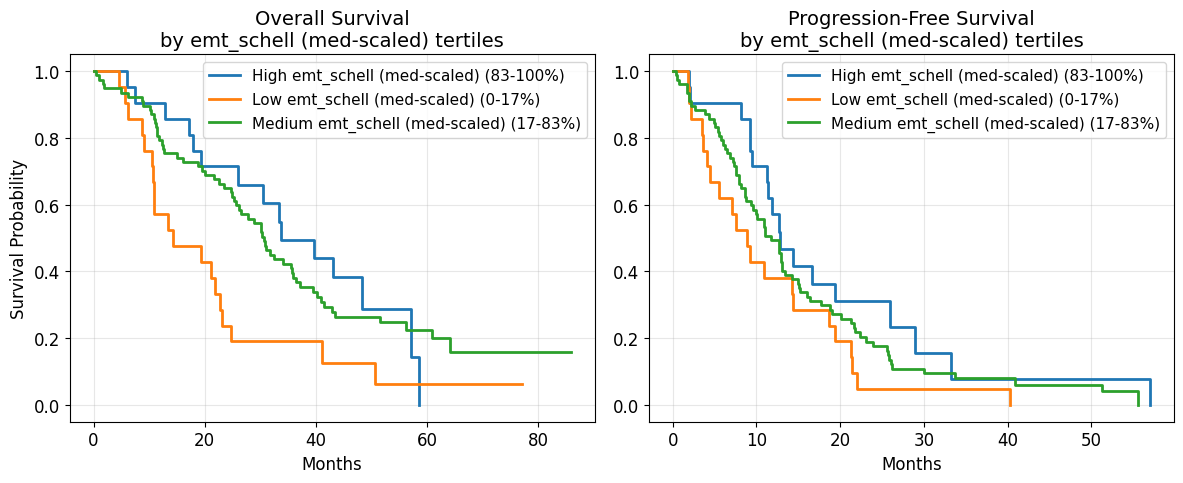


Медианная выживаемость для emt_schell (med-scaled) (тертили):
High emt_schell (med-scaled) (83-100%): OS = 33.7 мес | PFS = 12.8 мес
Low emt_schell (med-scaled) (0-17%): OS = 14.3 мес | PFS = 8.9 мес
Medium emt_schell (med-scaled) (17-83%): OS = 30.6 мес | PFS = 11.7 мес


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 1. Загрузка данных
data = pd.concat([
    pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/raw/ann_PRJNA805525.csv'),
    pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/cohort_2_expr_ann_emt_signatures.csv')
], axis=1)

# 2. Конвертация времени в месяцы
data['OS_months'] = data['OS'] / 30.44
data['PFS_months'] = data['PFS'] / 30.44

# 3. Получаем список всех EMT сигнатур
emt_signatures = [col for col in data.columns if col.startswith('EMT_SIGNATURE')]

# 4. Процентили для разделения на три группы
percentiles = [17, 83]  # Границы для 3 групп: 0-17%, 17-83%, 83-100%

# 5. Анализ для каждой EMT сигнатуры
for signature in emt_signatures:
    # Создаем фигуру с черными осями
    plt.figure(figsize=(12, 5))
    kmf = KaplanMeierFitter()
    
    # Убираем префикс и суффикс для названия
    clean_name = signature.replace('EMT_SIGNATURE_', '').replace('_med', ' (med-scaled)')
    
    # Вычисляем границы по процентилям
    p17, p83 = np.percentile(data[signature], percentiles)
    
    # Создаем группы
    conditions = [
        (data[signature] <= p17),
        (data[signature] > p17) & (data[signature] <= p83),
        (data[signature] > p83)
    ]
    choices = [
        f'Low {clean_name} (0-17%)',
        f'Medium {clean_name} (17-83%)', 
        f'High {clean_name} (83-100%)'
    ]
    data['Group'] = np.select(conditions, choices)
    
    # A. Overall Survival
    plt.subplot(1, 2, 1)
    for name, group in data.groupby('Group'):
        kmf.fit(group['OS_months'], group['OS_FLAG'], label=name)
        kmf.plot_survival_function(ci_show=False, linewidth=2)
    plt.title(f'Overall Survival\nby {clean_name} tertiles', color='black')
    plt.xlabel('Months', color='black')
    plt.ylabel('Survival Probability', color='black')
    plt.grid(True, alpha=0.3)
    
    # Устанавливаем черный цвет для осей и меток
    ax = plt.gca()
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    
    # B. Progression-Free Survival
    plt.subplot(1, 2, 2)
    for name, group in data.groupby('Group'):
        kmf.fit(group['PFS_months'], group['PFS_FLAG'], label=name)
        kmf.plot_survival_function(ci_show=False, linewidth=2)
    plt.title(f'Progression-Free Survival\nby {clean_name} tertiles', color='black')
    plt.xlabel('Months', color='black')
    plt.grid(True, alpha=0.3)
    
    # Устанавливаем черный цвет для осей и меток
    ax = plt.gca()
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    
    plt.tight_layout()
    plt.show()
    
    # 6. Вывод медианной выживаемости
    print(f"\nМедианная выживаемость для {clean_name} (тертили):")
    for name, group in data.groupby('Group'):
        kmf.fit(group['OS_months'], group['OS_FLAG'])
        median_os = kmf.median_survival_time_
        kmf.fit(group['PFS_months'], group['PFS_FLAG'])
        median_pfs = kmf.median_survival_time_
        print(f"{name}: OS = {median_os:.1f} мес | PFS = {median_pfs:.1f} мес")